# Traitement textuel

### Approches proposées:
- Un prétraitement des données texte
- deux approches de type “bag-of-words”, comptage simple de mots et Tf-idf
- une approche de type word/sentence embedding classique avec Word2Vec
- une approche de type word/sentence embedding avec BERT
- une approche de type word/sentence embedding avec USE

### Imports

In [1]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import tensorflow as tf
from wordcloud import WordCloud
import multiprocessing

import nltk
import string
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn import cluster, metrics, preprocessing, linear_model
from sklearn import manifold

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from glob import glob

#### Message d'avertissements

In [2]:
import warnings
warnings.filterwarnings("ignore")

#### Téléchargement

In [3]:
# nltk.download()
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('words')
# nltk.download('wordnet')

#### Import documents

In [4]:
data = pd.read_csv("./Data/flipkart_com-ecommerce_sample_1050.csv")
df = data.copy()
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

## Analyse Exploratoire

<Axes: >

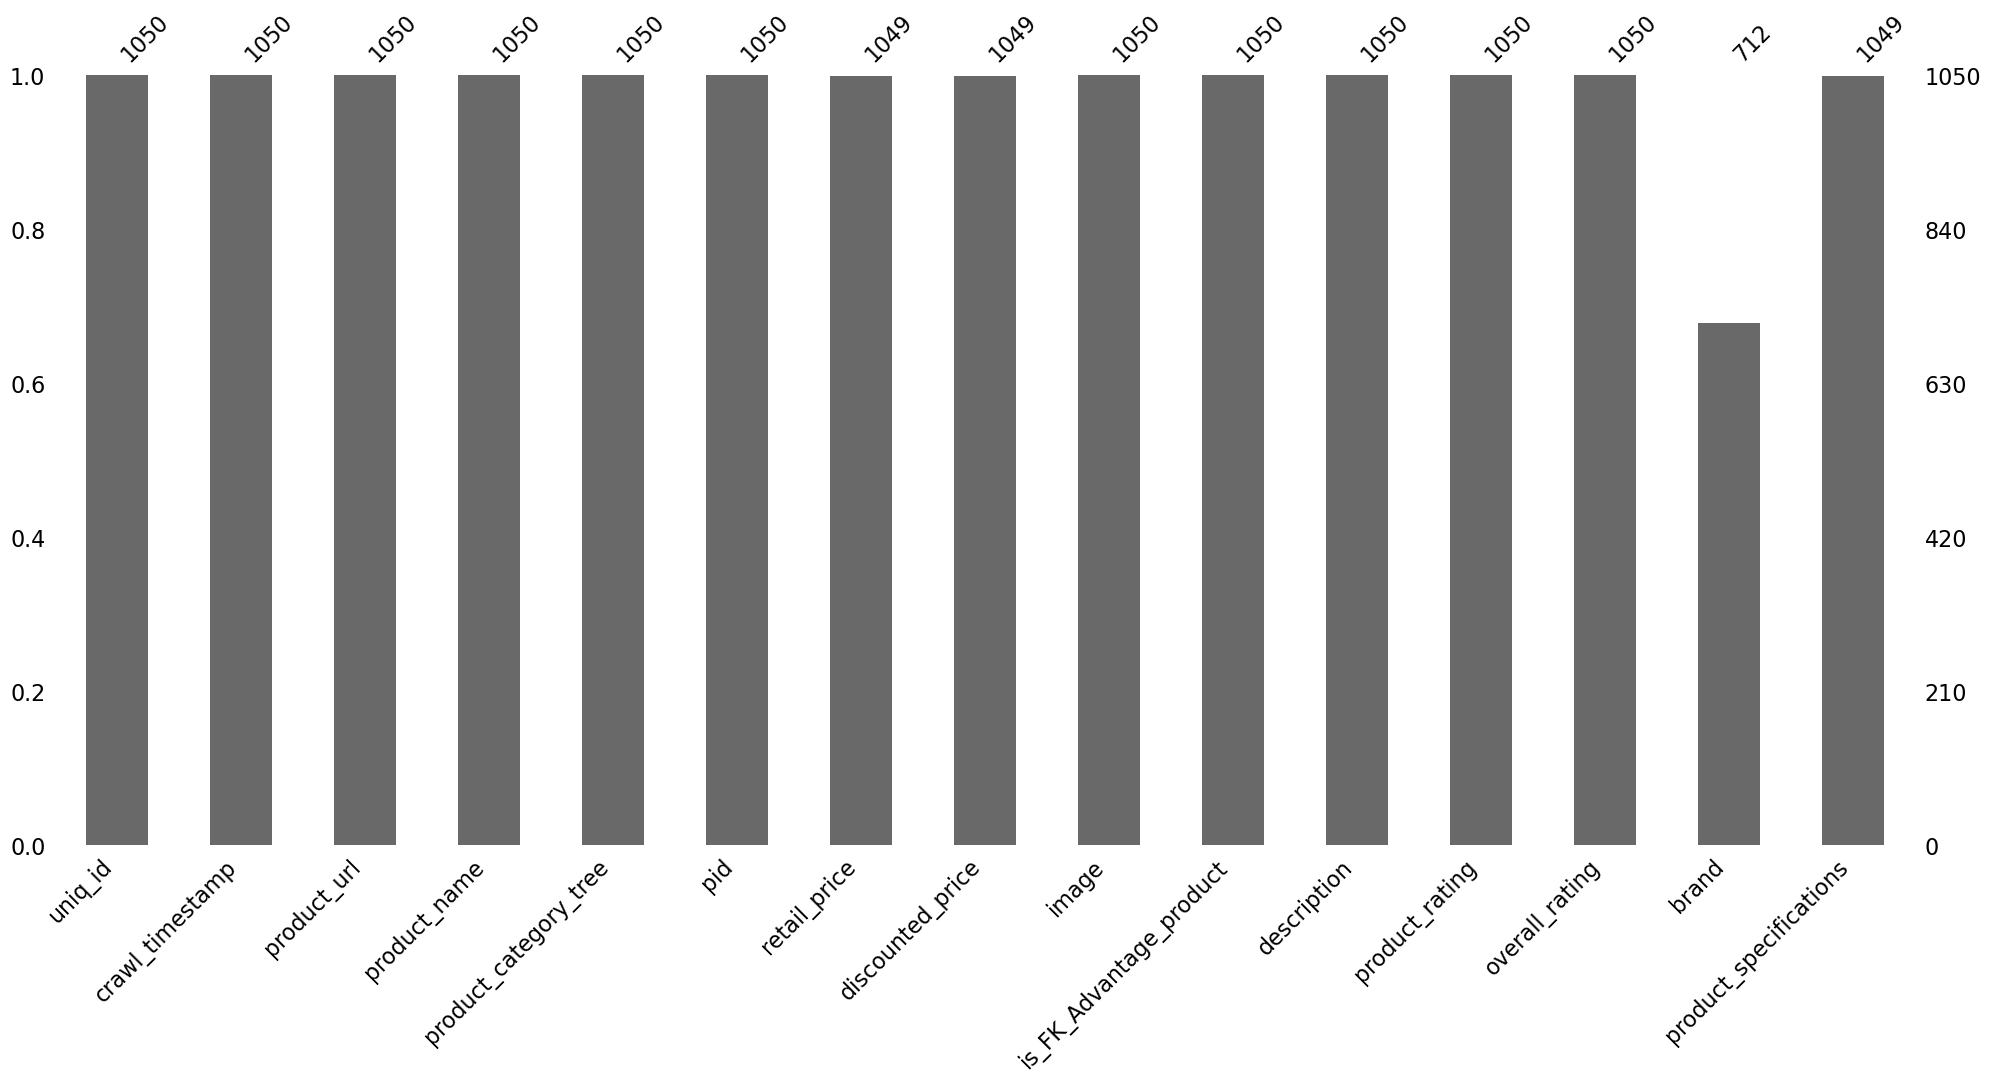

In [5]:
#Valeurs manquantes
msno.bar(df)

#### Séparation de l'arbre de catégorie

In [6]:
for r, l in df.iterrows():
    cat = l["product_category_tree"]
    cat = cat.replace('["', '')
    cat = cat.replace('"]', '')
    list_cat = cat.split('>>')
    count = len(list_cat)

    #Catégories
    df.loc[r,'main_category'] = list_cat[0] 
    #Sous-catégories
    df.loc[r,'2th_category'] = list_cat[1] 
    #Nombre de branches de l'arbre
    df.loc[r, 'num_categories'] = count


In [7]:
df.shape

(1050, 18)

In [8]:
df['main_category'].value_counts()

Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: main_category, dtype: int64

In [9]:
df['2th_category'].nunique()

63

#### Répartitions des catégories et des sous-catégories

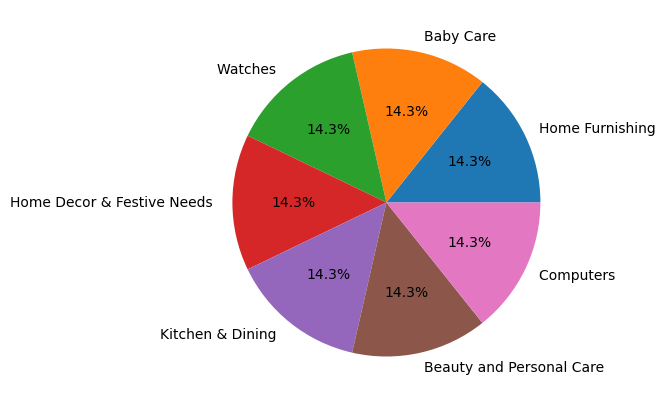

In [10]:
# Catégories
cat_1 = df['main_category'].value_counts()

plt.figure(figsize=(20,5))
plt.pie(cat_1, labels= cat_1.index, autopct='%1.1f%%')
plt.savefig("./Visualisations/Analyse/Répartitions_des_catégories", bbox_inches='tight')
plt.show()

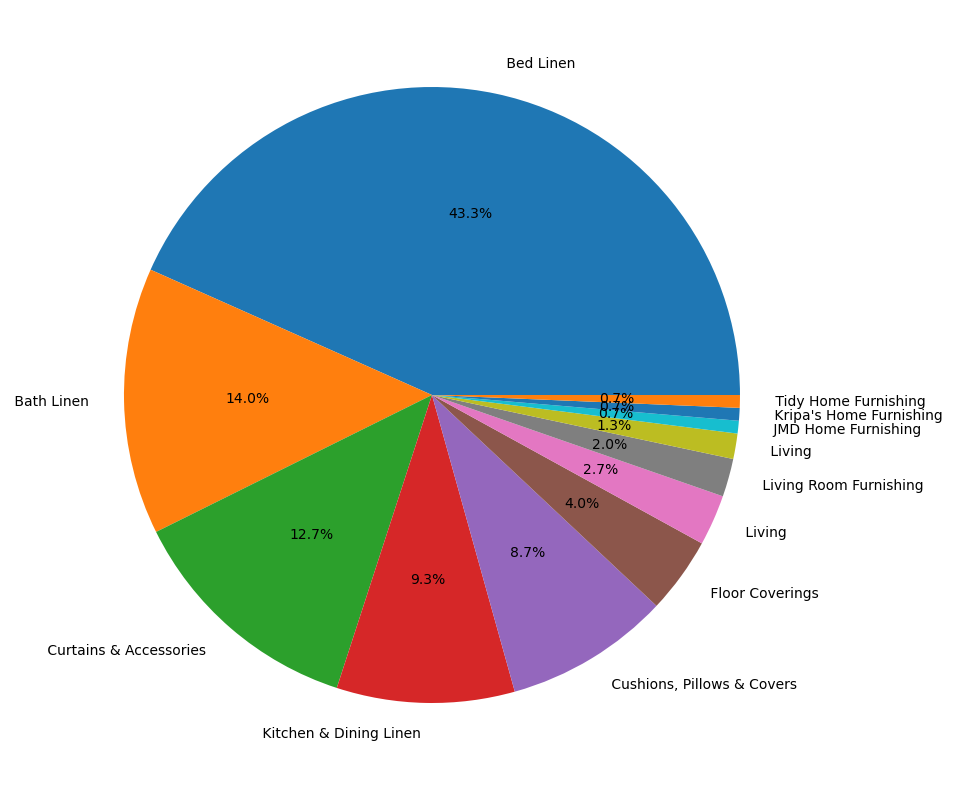

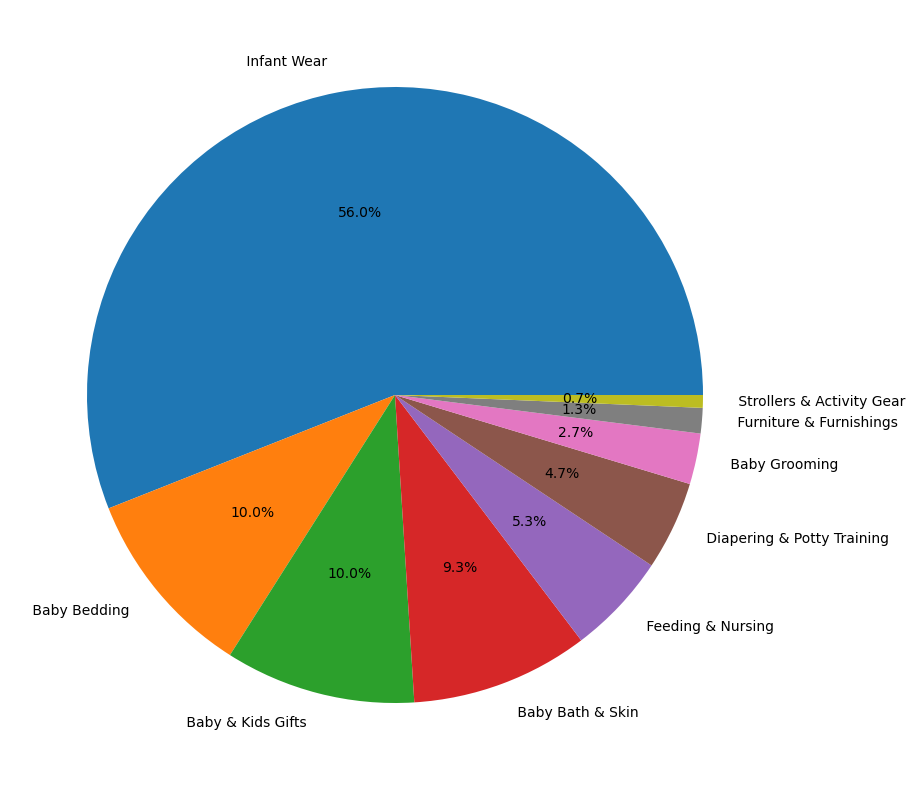

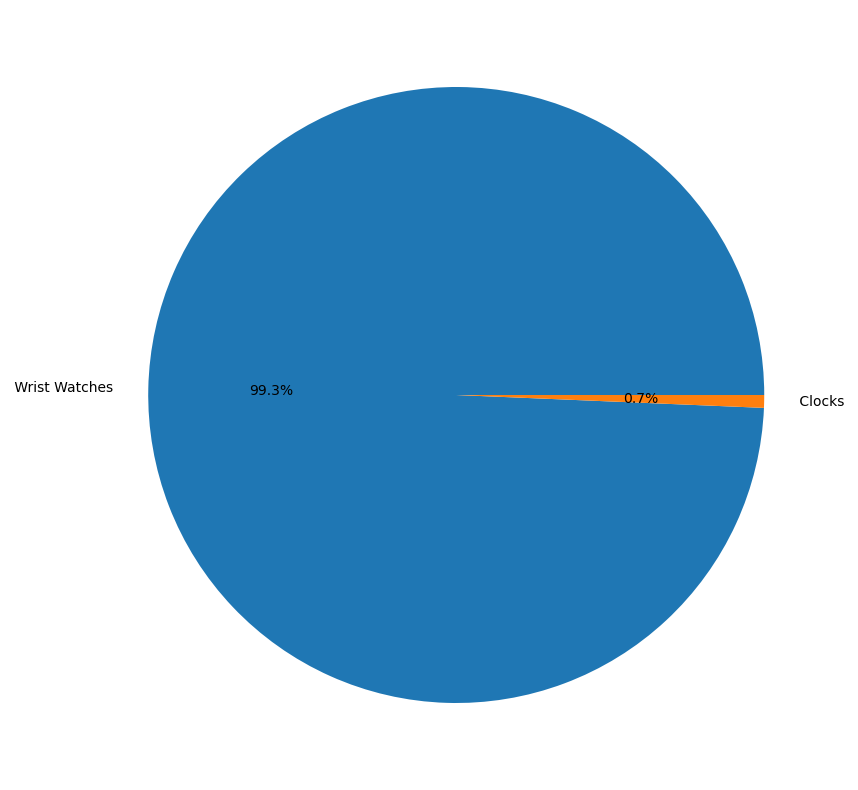

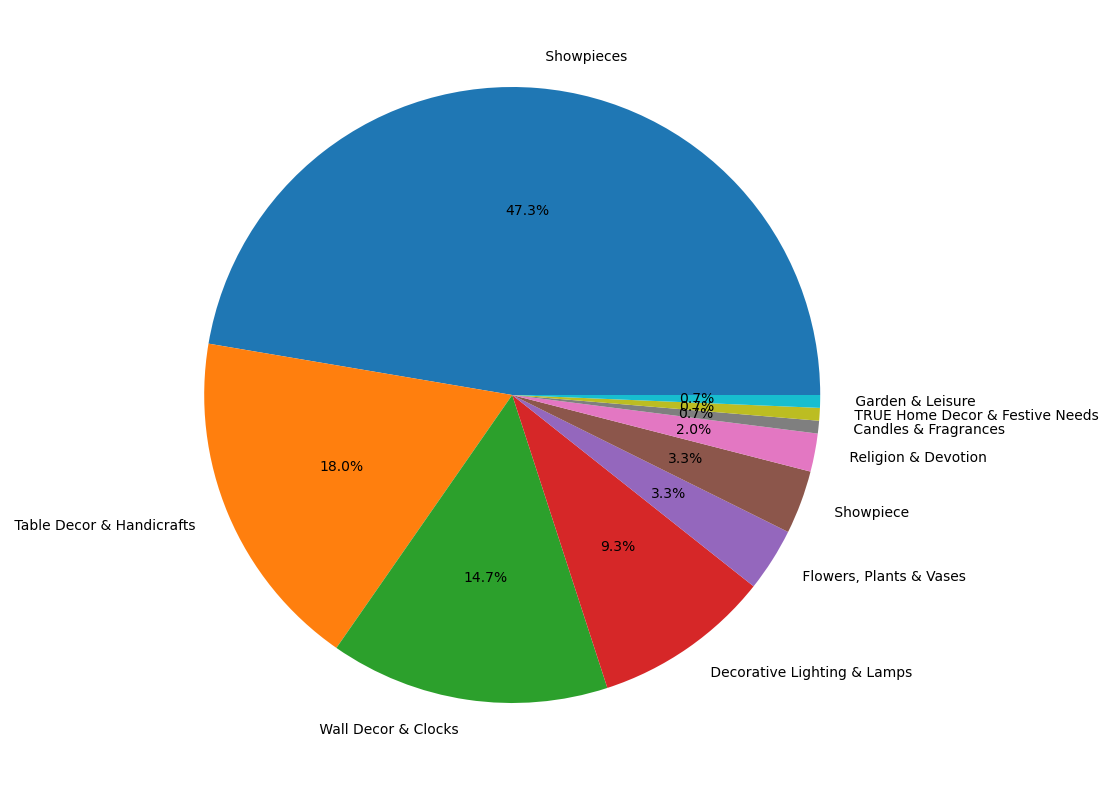

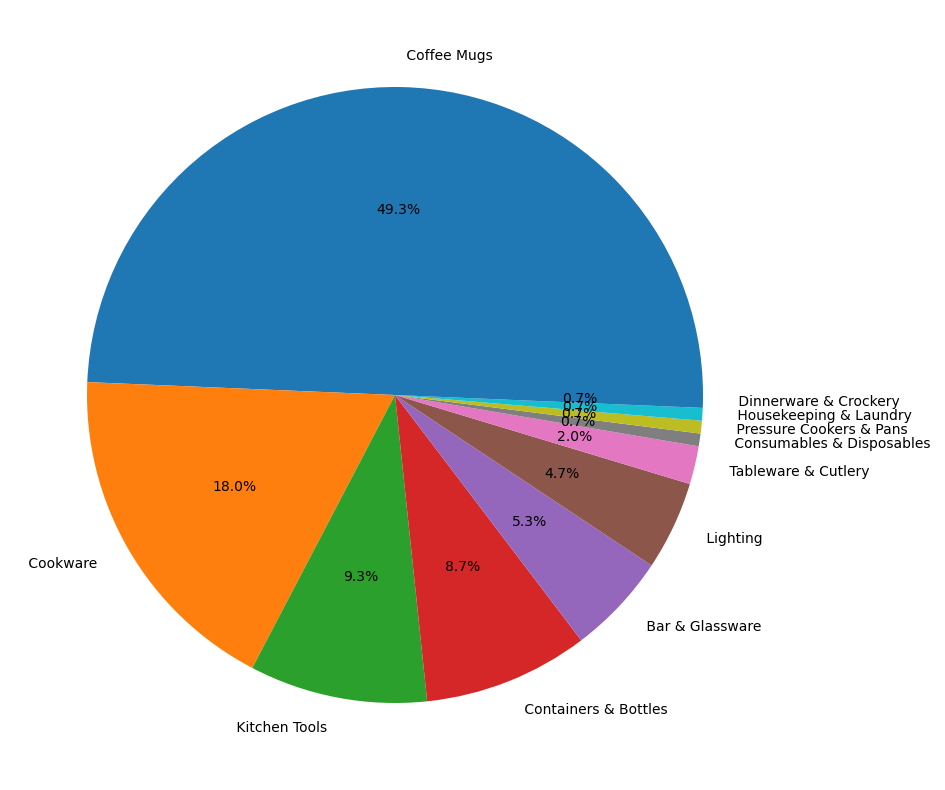

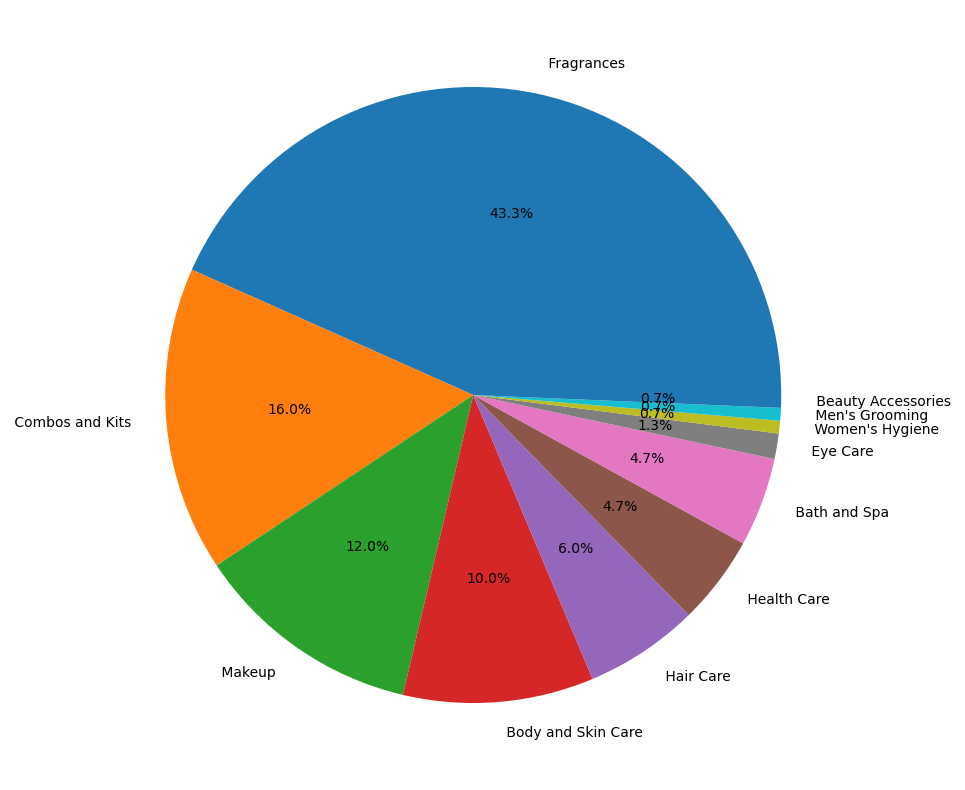

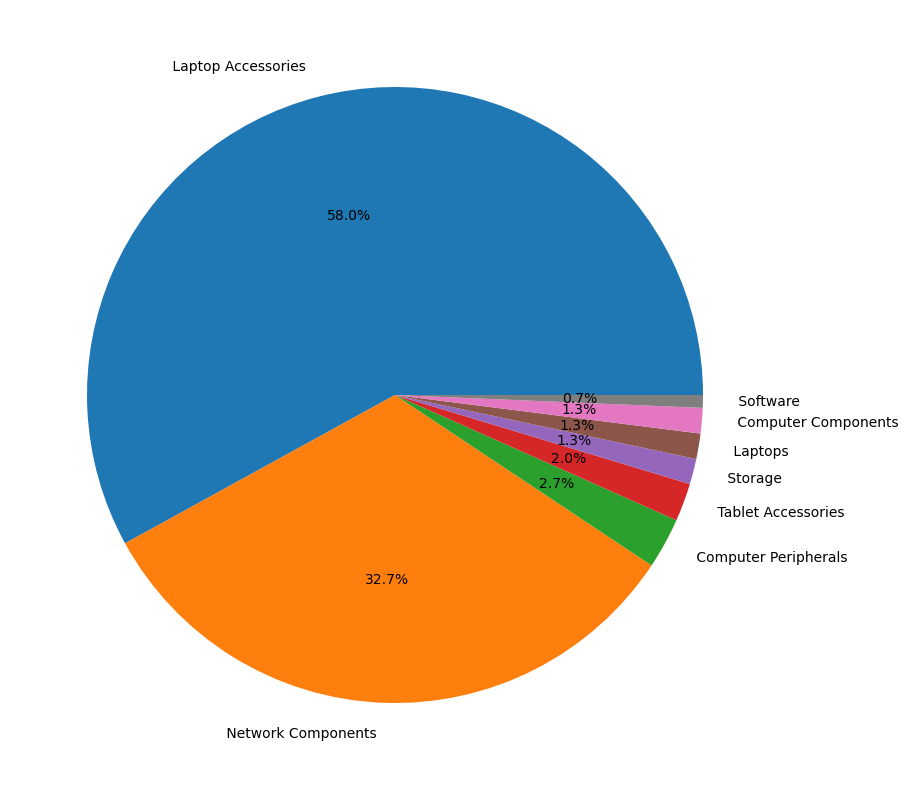

In [11]:
#Visualisation de sous-catégories

cat_main = df['main_category'].unique()

for n in cat_main:
    
    df_int = df.loc[df['main_category']==n]
    cat_2th = df_int['2th_category'].value_counts()

    plt.figure(figsize=(20,10))
    plt.pie(cat_2th, labels= cat_2th.index, autopct='%1.1f%%')
    plt.savefig("./Visualisations/Analyse/Répartitions_des_sous_catégories_de_{}".format(n), bbox_inches='tight')
    plt.show()

In [151]:
df.to_csv("./Data/DataTraite.csv")

## Nettoyage des données textuelles

- Elimination de la ponctuation, caractères spéciaux, des nombres, des stopwords
- Mise en forme, supression des majuscules
- Stemming et lematisation:
    - Stemming : Technique de normalisation qui consiste qui sépare les préfixes et les suffixes des mots pour obtenir le mot racine, et permet de réduire les mots
    - Lemmatisation: Technique de normalisation qui réduire le vocabulaire en regroupant les synonymes, en regroupant les verbes conjugués sous une même racine

#### Fonction

In [12]:
def Preprocess_listofSentence(listofSentence, sw=True, func='default'):
    
    #Fonction qui permet le nettoyage des données textuelles, avec ou sans l'élimination des stopwords et/ ou la lemmisation
    
    preprocess_list = []
    #Dictionnaire Stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    #Dictionnaire de mots
    words = set(nltk.corpus.words.words())
    lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer('english')
    
    for sentence in listofSentence :
        #Ponctuation
        sentence_w_punct = "".join([i.lower() for i in sentence if i not in string.punctuation])
        #Chiffres et nombres
        sentence_w_num = ''.join(i for i in sentence_w_punct if not i.isdigit())
        #Tokenisation
        tokenize_sentence = nltk.tokenize.word_tokenize(sentence_w_num)
        #Suppression stopwords
        if sw==True:
            words_w_stopwords = [i for i in tokenize_sentence if i not in stopwords]
        else:
            words_w_stopwords = tokenize_sentence
        #Lemmatisation
        if func == "l":
            words_lemmatize = (lemmatizer.lemmatize(w) for w in words_w_stopwords)
        #Stemming
        elif func == 's':
            words_lemmatize = (stemmer.stem(w) for w in words_w_stopwords)
        else:
            words_lemmatize = words_w_stopwords
        
        sentence_clean = ' '.join(w for w in words_lemmatize if w.lower() in words or not w.isalpha())
        preprocess_list.append(sentence_clean)
        
    return preprocess_list 

On combine le titre du produit et la description pour avoir de meilleurs résultats

In [13]:
df.loc[:,'name_desc'] = df.loc[:,'product_name'] + ' ' + df.loc[:,'description']

In [14]:
df.head(5)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications     main_category  \
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing    
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care    
2  {"product_specification"=>[{"key"=>"Material",...        Baby Care    
3  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing    
4  {"product_specification"=>[{"key"=>"Machine Wa...  Home Furnishing    

               2th_category  num_categories  \
0   Curtains & Accessories              4.0   
1         Baby Bath & Skin              5.0   
2         Baby Bath & Skin              5.0   
3                Bed Linen              5.0   
4                Bed Linen              5.0   

                                           name_desc  
0  Elegance Polyester Multicolor Abstract Eyelet ...  
1  Sathiyas Cotton Bath Towel Specifications of S...  
2  Eurospa Cotton Terry Face Towel Set Key Featur...  
3  SANTOSH ROYAL FASHION Cotton Printed King size...  
4  Jaipur Print Cotton Floral King sized Double B...

### Nettoyage

In [15]:
# Sans ponctuantion
df.loc[:, 'name_desc_clean'] = Preprocess_listofSentence(df['name_desc'], sw=False)
# Sans stopwords
df.loc[:, 'name_desc_clean_wo_sw'] = Preprocess_listofSentence(df['name_desc'])
# Avec lemmatisation
df.loc[:, 'name_desc_clean_lem'] = Preprocess_listofSentence(df['name_desc'], func='l')
# Avec Stemming
df.loc[:, 'name_desc_clean_stem'] = Preprocess_listofSentence(df['name_desc'], func='s')

#### Comparaison

In [16]:
df.loc[0,'name_desc']

'Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant

In [17]:
df.loc[0,'name_desc_clean_wo_sw']

'elegance polyester multicolor abstract eyelet door curtain key elegance polyester multicolor abstract eyelet door curtain floral polyester multicolor abstract eyelet door curtain height pack price curtain look curtain made high quality polyester eyelet style stitch metal room environment romantic curtain ant wrinkle anti shrinkage elegant home bright modernistic appeal attention sure steal hearts contemporary eyelet valance slide smoothly draw apart first thing morning welcome bright sun want wish good morning whole world draw close evening create special joyous beauty given soothing bring home elegant curtain softly light room get right amount elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model id duster color multicolor length box number contents package pack package body design material polyester'

In [18]:
df.loc[0,'name_desc_clean_lem']

'elegance polyester multicolor abstract eyelet door curtain key feature elegance polyester multicolor abstract eyelet door curtain floral polyester multicolor abstract eyelet door curtain height pack price r curtain look curtain made high quality polyester feature eyelet style stitch metal make room environment romantic curtain ant wrinkle anti shrinkage elegant home bright modernistic appeal design attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model id duster color multicolor dimension length box number content sale package pack sale package curtain body desig

In [19]:
df.loc[0,'name_desc_clean_stem']

'multicolor abstract eyelet door curtain key multicolor abstract eyelet door curtain floral multicolor abstract eyelet door curtain height pack price curtain look curtain made high eyelet style stitch metal make room environ curtain ant anti home bright modernist appeal design attent sure steal heart eyelet curtain slide smooth draw apart first thing morn bright sun ray want wish good morn whole world draw close even creat special moment joyous beauti given sooth print bring home curtain soft filter light room get right amount multicolor abstract eyelet door curtain height pack general brand design door type eyelet model name abstract door curtain set model id duster color multicolor length box number content sale pack sale curtain design'

In [20]:
df.head(5)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product  ...                  brand  \
0                    False  ...               Elegance   
1                    False  ...               Sathiyas   
2                    False  ...                Eurospa   
3                    False  ...  SANTOSH ROYAL FASHION   
4                    False  ...           Jaipur Print   

                              product_specifications     main_category  \
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing    
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care    
2  {"product_specification"=>[{"key"=>"Material",...        Baby Care    
3  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing    
4  {"product_specification"=>[{"key"=>"Machine Wa...  Home Furnishing    

               2th_category num_categories  \
0   Curtains & Accessories             4.0   
1         Baby Bath & Skin             5.0   
2         Baby Bath & Skin             5.0   
3                Bed Linen             5.0   
4                Bed Linen             5.0   

                                           name_desc  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1  Sathiyas Cotton Bath Towel Specifications of S...   
2  Eurospa Cotton Terry Face Towel Set Key Featur...   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                     name_desc_clean  \
0  elegance polyester multicolor abstract eyelet ...   
1  cotton bath towel of cotton bath towel bath to...   
2  cotton terry face towel set key of cotton terr...   
3  royal fashion cotton printed king sized double...   
4  print cotton floral king sized double key of p...   

                               name_desc_clean_wo_sw  \
0  elegance polyester multicolor abstract eyelet ...   
1  cotton bath towel cotton bath towel bath towel...   
2  cotton terry face towel set key cotton terry f...   
3  royal fashion cotton printed king sized double...   
4  print cotton floral king sized do

Observations de nuage de mots pour répérer des mots qui pourraient supprimés

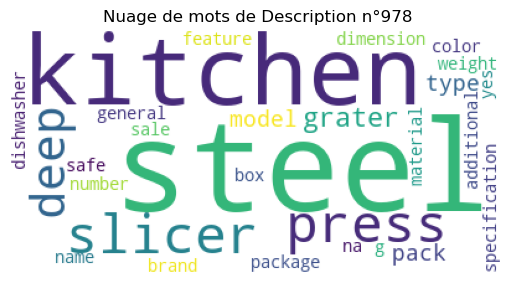

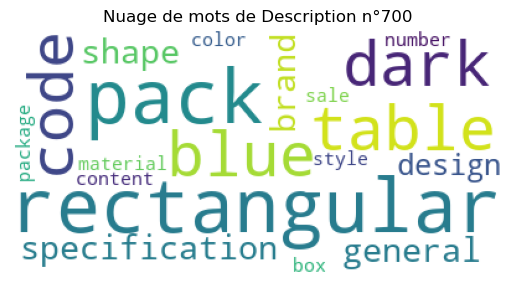

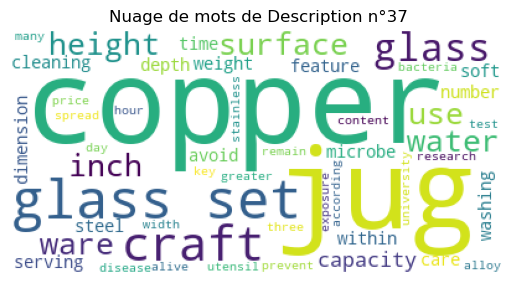

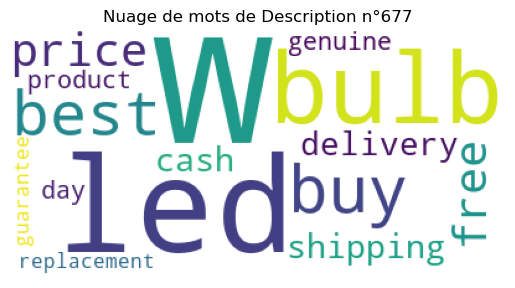

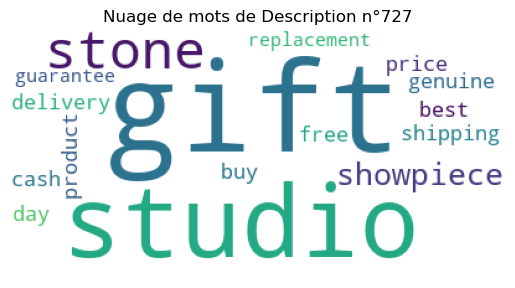

In [21]:
for n in range(5):
    
    i = random.randrange(0,df.shape[0])
    wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(df.loc[i,'name_desc_clean_lem'])
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Nuage de mots de Description n°{}".format(i))
    plt.savefig("./Visualisations/Analyse/Nuage de mots de Description aléatoire n°{}".format(n+1))
    plt.show()

#### Observations :
- On peut voir qu'il y a des mots qui pourrait être suprimmé qui on un rapport général avec la vente
- On va créer une liste qui rassemble ses mots et les retirer

In [22]:
dropwords = ['free', 'product', 'buy', 'sell', 'delivery', 'shipping', 'ship', 'present','shop', 'item', 'cash', 'price',\
             'warranty', 'replacement', 'guarantee', 'offering', 'offer', 'perfect','gift', 'genuine', 'best', 'day',\
             'discount', 'ideal','sale']

def Preprocess_listofSentence_2(listofSentence, dropwords, sw=True, func='default'):
    
    #Fonction qui permet le nettoyage des données textuelles, avec ou sans l'élimination des stopwords et/ ou la lemmisation
    
    preprocess_list = []
    #Dictionnaire Stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    #Dictionnaire de mots
    words = set(nltk.corpus.words.words())
    lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer('english')
    
    for sentence in listofSentence :
        #Ponctuation
        sentence_w_punct = "".join([i.lower() for i in sentence if i not in string.punctuation])
        #Chiffres et nombres
        sentence_w_num = ''.join(i for i in sentence_w_punct if not i.isdigit())
        #Tokenisation
        tokenize_sentence = nltk.tokenize.word_tokenize(sentence_w_num)     
        
        tokenize_sentence = [w for w in tokenize_sentence if w.lower() in words or not w.isalpha()]
        #Suppression stopwords
        words_w_stopwords = [i for i in tokenize_sentence if i not in stopwords]
        #Suppression des dropwords
        word_w_dropwords = [i for i in words_w_stopwords if i not in dropwords]
        #Lemmatisation
        if func == "l":
            words_lemmatize = (lemmatizer.lemmatize(w) for w in word_w_dropwords)
        #Stemming
        elif func == 's':
            words_lemmatize = (stemmer.stem(w) for w in word_w_dropwords)
        else:
            words_lemmatize = word_w_dropwords
        
        sentence_clean = ' '.join(w for w in words_lemmatize)
        preprocess_list.append(sentence_clean)
        
    return preprocess_list 

# def drop_words(ListOfSentence, dropwords):
#     preprocess_list =[]
#     for sentence in ListOfSentence:
#         tokenize_sentence = nltk.tokenize.word_tokenize(sentence)
#         word_w_dropwords = [i for i in tokenize_sentence if i not in dropwords]
#         sentence_clean = ' '.join(w for w in word_w_dropwords)
#         preprocess_list.append(sentence_clean)
        
#     return preprocess_list
        
# Sans stopwords
df.loc[:, 'name_desc_clean_wo_sw_2'] = Preprocess_listofSentence_2(df['name_desc'], dropwords)
# Avec lemmatisation
df.loc[:, 'name_desc_clean_lem_2'] = Preprocess_listofSentence_2(df['name_desc'], dropwords, func='l')
# Avec Stemming
df.loc[:, 'name_desc_clean_stem_2'] = Preprocess_listofSentence_2(df['name_desc'], dropwords, func='s')

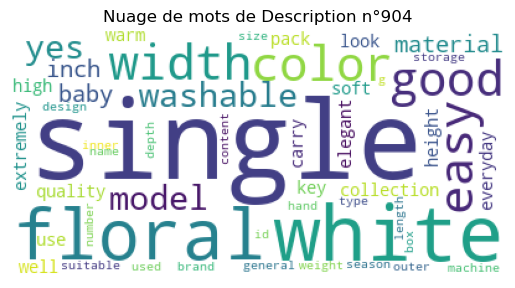

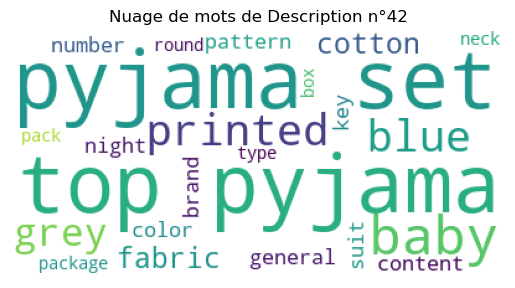

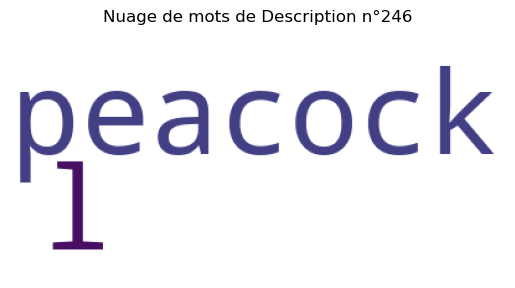

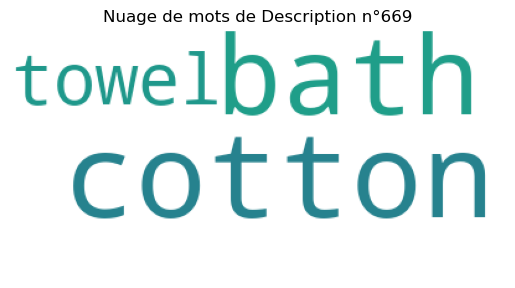

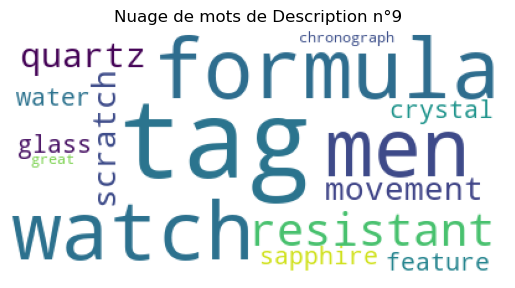

In [23]:
for n in range(5):
    
    i = random.randrange(0,df.shape[0])
    wordcloud_2 = WordCloud(background_color = 'white', max_words = 50).generate(df.loc[i,'name_desc_clean_lem_2'])
    plt.imshow(wordcloud_2)
    plt.axis("off")
    plt.title("Nuage de mots de Description n°{}".format(i))
    plt.savefig("./Visualisations/Analyse/Nuage de mots de Description aléatoire n°{}(dropwords)".format(n+1))
    plt.show()

# Vectorisation et comparaison classification

In [24]:
df_model = pd.DataFrame(columns = ['Train_Accuracy', 'Train_Time', 'Test_Accuracy', 'Test_Time'])

## Bag-of-words

- Stratégie "bag-of-words", "bag-of-n-grams" via CountVectorizer et TfidfVectorizer
- Visualisations des différents sujets via LDA et NMF

### Fonctions utilisées

In [25]:
def vec_comp(X, n_gram):
    
    #Fonction qui vectorise le texte via 2 modèles
    #Determine des clusters via K-Means apres une réduction de dimension réalisé via t-SNE
    
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=5000, init="random")
    
    #Comptage simple
    cv = CountVectorizer(ngram_range =(n_gram, n_gram))
    cv_t = cv.fit_transform(X)
    #TF-IDF
    ctf = TfidfVectorizer(ngram_range =(n_gram, n_gram))
    ctf_t = ctf.fit_transform(X)

    #Réduction de dimension et clustering
    ##Comptage simple
    cv_tsne = tsne.fit_transform(cv_t)
    cls_cv = cluster.KMeans(n_clusters=7).fit(cv_tsne)
    lab_cv = cls_cv.labels_
    ##TF-IDF
    ctf_tsne = tsne.fit_transform(ctf_t)
    cls_ctf = cluster.KMeans(n_clusters=7).fit(ctf_tsne)
    lab_ctf = cls_ctf.labels_
    
    cat = preprocessing.LabelEncoder().fit_transform(df["main_category"])
    
    #ARI
    ari_cv = metrics.adjusted_rand_score(cat, lab_cv)
    ari_ctf = metrics.adjusted_rand_score(cat, lab_ctf)
    
    #Visualisation
    colors=['#ffd966', '#f44336', '#2986cc', '#00FF00', '#FF00FF', '#ff7f00', "#ffa6b3"]
    
    ##CountVectorizer
    plt.figure(figsize=(20,6))
    plt.subplot(1,2,1)
    sns.scatterplot(x=  cv_tsne[:,1], y= cv_tsne[:,0], hue=cat, palette=colors)
    plt.xlabel("2eme Composante")
    plt.ylabel("1ere Composante")
    plt.text
    plt.title("CountVectorizer avec les labels", fontsize=16)
    ##TF-IDF
    plt.subplot(1,2,2)
    sns.scatterplot(x=  ctf_tsne[:,1], y= ctf_tsne[:,0], hue=cat, palette=colors)
    plt.xlabel("2eme Composante")
    plt.ylabel("1ere Composante")
    plt.title("TfidfVectorizer avec les labels", fontsize=16)
    plt.savefig("./Visualisations/Bag_of_words/Comparaison_comptage_simple_vs_TF-id_{}_n_gram_{}".format(X.name, n_gram))
    plt.show()
    
    print('ARI CountVectorizer =', ari_cv)
    print('ARI TfidfVectorizer =', ari_ctf)
    
    return [ari_cv, ari_ctf]

In [26]:
def visu_topic(X,sujet):
    
    #Fonction qui vectorise le texte et puis Topic modeling via LDA et NMF
    #Affiche les 10 mots qui représente le mieux les catégories
    
    #Comptage simple
    cv = CountVectorizer()
    cv_t = cv.fit_transform(X)
    cv_feature_names = cv.get_feature_names_out()
    #TF-IDF
    ctf = TfidfVectorizer()
    ctf_t = ctf.fit_transform(X)
    ctf_feature_names = ctf.get_feature_names_out()
    
    #LDA
    lda = LatentDirichletAllocation(n_components=sujet, max_iter=10, learning_method='online')
    lda_cv = lda.fit(cv_t)
    
    #NMF
    nmf = NMF(n_components=sujet, l1_ratio=.5, init='nndsvd')
    nmf_ctf = nmf.fit(ctf_t)
    

    print("Mots qui representent les catégories via CountVectorizer et LDA")
    plt.figure(figsize=(40,12))
    for topic_idx, topic in enumerate(lda_cv.components_):
#         print("\nCatégorie {}:".format(topic_idx))
#         print(" ".join([cv_feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))
        top_features_ind = topic.argsort()[:-10 - 1 : -1]
        top_features = [cv_feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        plt.subplot(2,4,(topic_idx+1))
        plt.barh(top_features, weights)
        plt.title('Categorie {}'.format(topic_idx))
        plt.gca().invert_yaxis()
    plt.subplots_adjust(wspace=0.30, hspace=0.30)
    plt.savefig("./Visualisations/Topic_modeling/Topic_modeling_CV_LDA_{}".format(X.name))
    plt.show()
    

    print("\n\nMots qui representent les catégories via TfidfVectorizer et NMF")
    plt.figure(figsize=(40,12))
    for topic_idx, topic in enumerate(nmf_ctf.components_):
#         print("\nCatégorie {}:".format(topic_idx))
#         print(" ".join([ctf_feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))
        top_features_ind = topic.argsort()[:-10 - 1 : -1]
        top_features = [ctf_feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        plt.subplot(2,4,(topic_idx+1))
        plt.barh(top_features, weights)
        plt.title('Categorie {}'.format(topic_idx))
        plt.gca().invert_yaxis()
    plt.subplots_adjust(wspace=0.30, hspace=0.30)
    plt.savefig("./Visualisations/Topic_modeling/Topic_modeling_TFID_NMF_{}".format(X.name))
    plt.show()
    


### Bag-of-words

- Comparaison des normalisations et nettoyages avec les modèles CountVectorizer et TfidVectorizer
- Apprentissage non supervisé et comparaison avec les topics (ARI)
- Visualisation grace a t-SNE

In [27]:
df_bagw = pd.DataFrame(columns = ['ARI_Count', 'ARI_Tfidf'])

#### Sans les stopwords

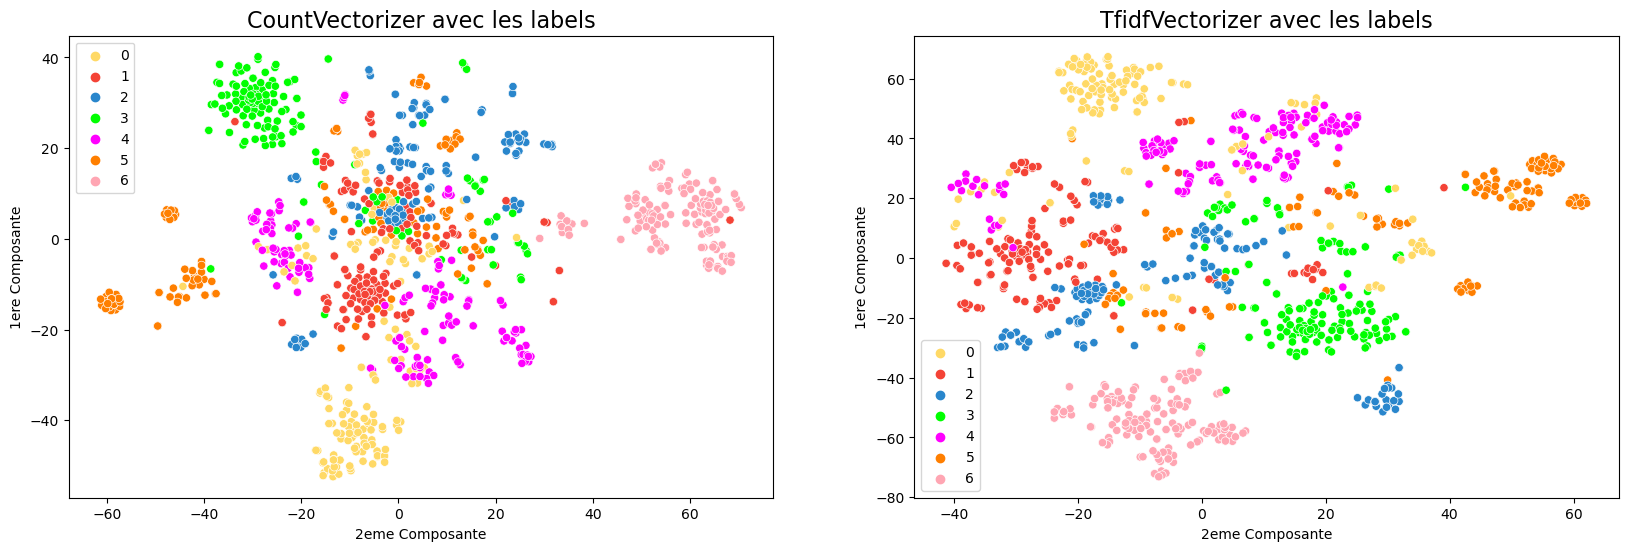

ARI CountVectorizer = 0.3541693357299158
ARI TfidfVectorizer = 0.49068126346366886


In [28]:
X = df['name_desc_clean_wo_sw']
X.name = 'Sans_stopwords'
ari_x = vec_comp(X,1)
df_bagw.loc['BoW_wo_sw',:] = ari_x

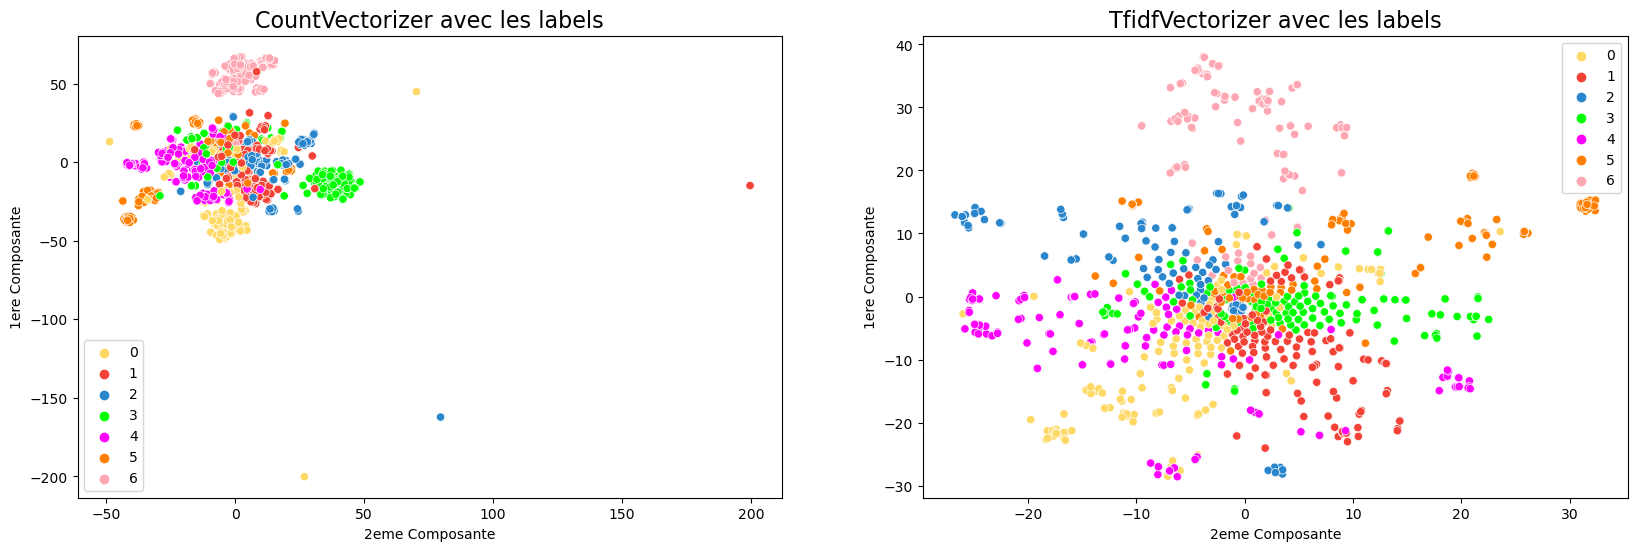

ARI CountVectorizer = 0.3765389544030783
ARI TfidfVectorizer = 0.22656671378674828


In [29]:
X0 = df['name_desc_clean_wo_sw_2']
X0.name = 'Sans_stopwords_dw'
ari_x0 = vec_comp(X0,1)
df_bagw.loc['BoW_wo_sw_dw',:] = ari_x0

#### Avec Stemming

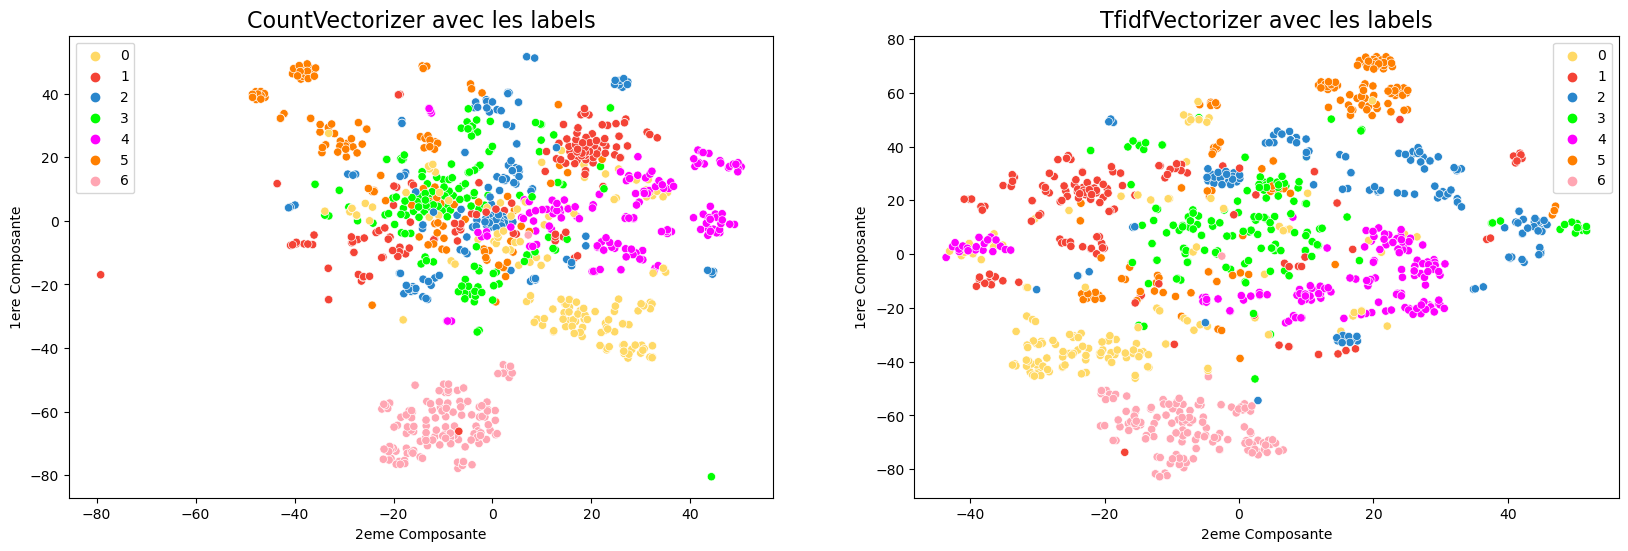

ARI CountVectorizer = 0.3420078236176495
ARI TfidfVectorizer = 0.3833026817818445


In [30]:
X1 = df['name_desc_clean_stem']
X1.name = 'Avec_Stemming'
ari_x1 = vec_comp(X1,1)
df_bagw.loc['BoW_stem',:] = ari_x1

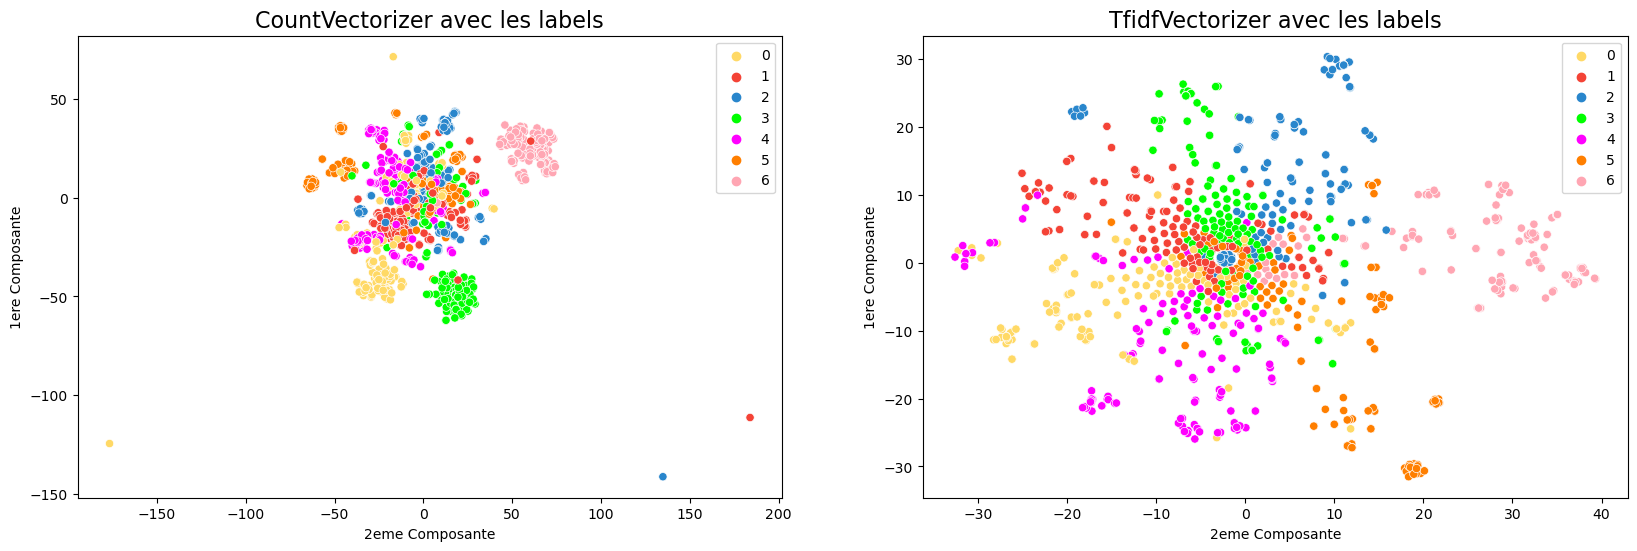

ARI CountVectorizer = 0.36685561737217987
ARI TfidfVectorizer = 0.30873936679129155


In [31]:
X2 = df['name_desc_clean_stem_2']
X2.name = 'Avec_Stemming_dw'
ari_x2 = vec_comp(X2,1)
df_bagw.loc['BoW_stem_dw',:] = ari_x2

#### Avec Lemmatisation

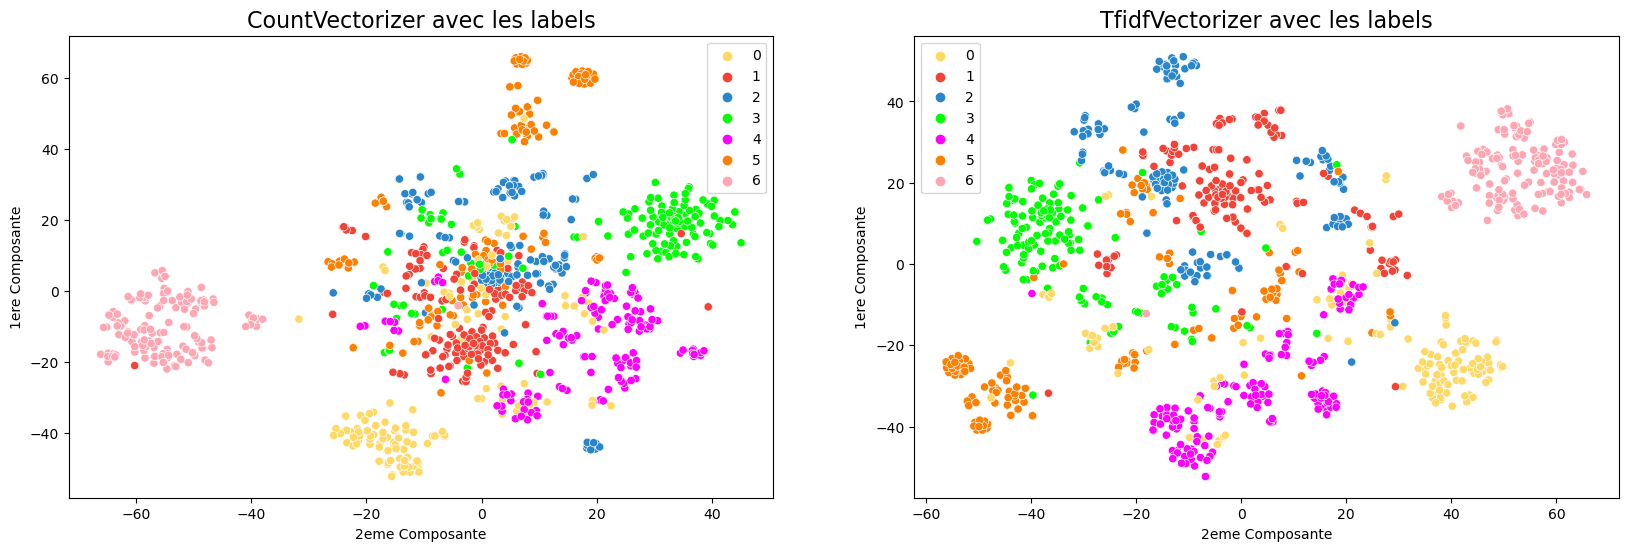

ARI CountVectorizer = 0.457318669938528
ARI TfidfVectorizer = 0.4985970405727159


In [32]:
X3 = df['name_desc_clean_lem']
X3.name = 'Avec_Lemmatisation'
ari_x3= vec_comp(X3,1)
df_bagw.loc['BoW_lem',:] = ari_x3

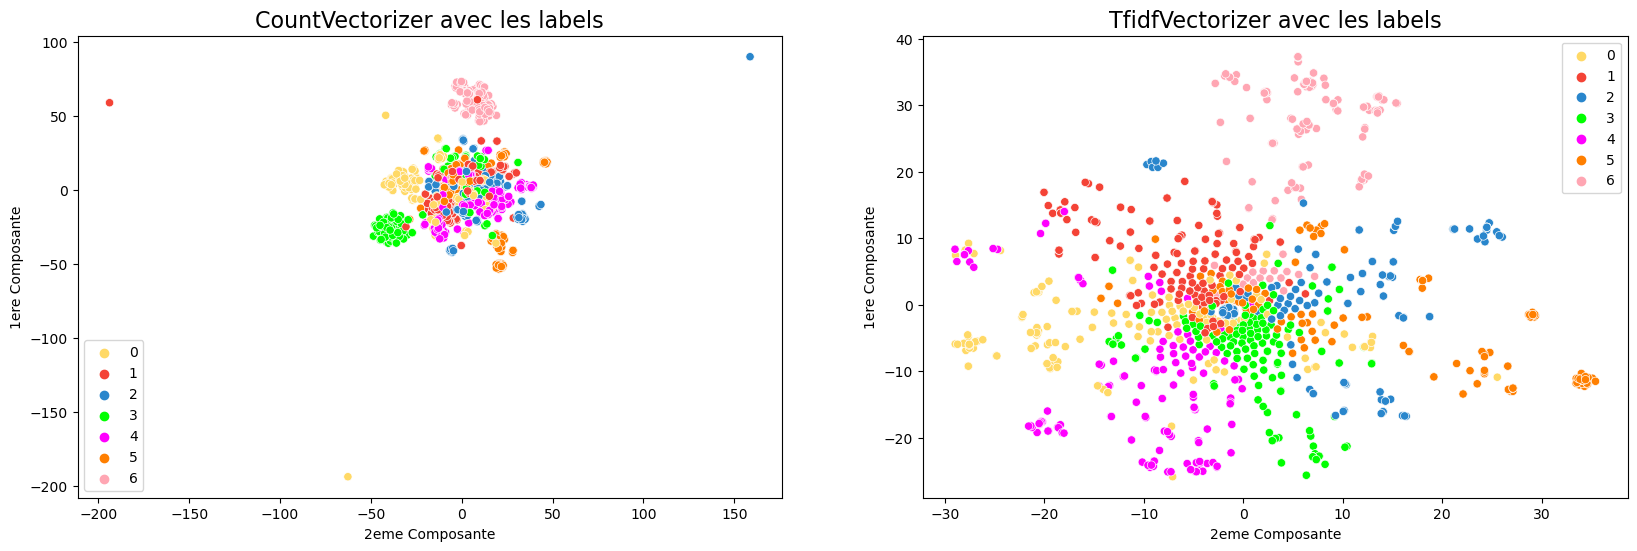

ARI CountVectorizer = 0.3300497533343962
ARI TfidfVectorizer = 0.2227083402992427


In [33]:
X4 = df['name_desc_clean_lem_2']
X4.name = 'Avec_Lemmatisation_dw'
ari_x4 = vec_comp(X4,1)
df_bagw.loc['BoW_lem_dw',:] = ari_x4

In [34]:
df_bagw

ARI_Count ARI_Tfidf
BoW_wo_sw     0.354169  0.490681
BoW_wo_sw_dw  0.376539  0.226567
BoW_stem      0.342008  0.383303
BoW_stem_dw   0.366856  0.308739
BoW_lem       0.457319  0.498597
BoW_lem_dw     0.33005  0.222708

### Bag-of n-grams

- Test avec des bigrammes, puis avec des trigrammes

In [35]:
df_bagn = pd.DataFrame(columns = ['ARI_Count', 'ARI_Tfidf'])

#### Sans Stopwords

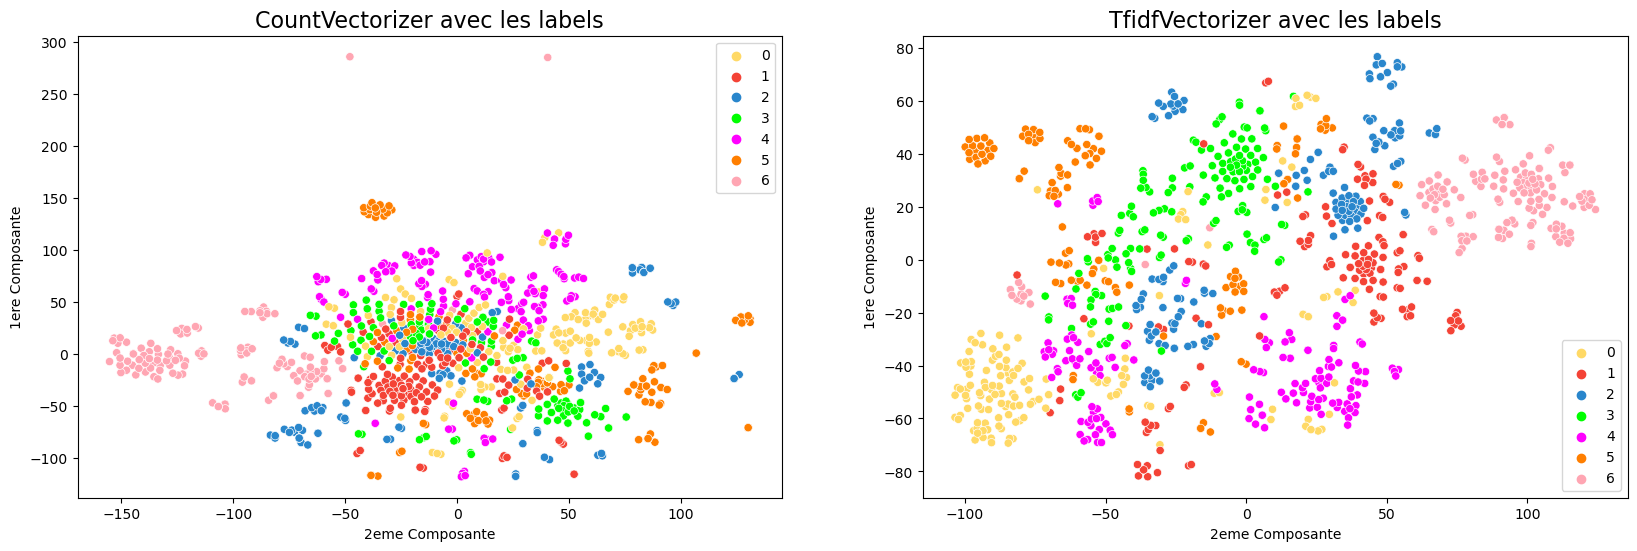

ARI CountVectorizer = 0.19969947558188325
ARI TfidfVectorizer = 0.3308988578474538


In [36]:
X_b= df['name_desc_clean_wo_sw']
X_b.name = 'sans_stopwords'


#bigrammes
ari_xb= vec_comp(X_b,2)
df_bagn.loc['BoN_wo_sw_bi',:] = ari_xb

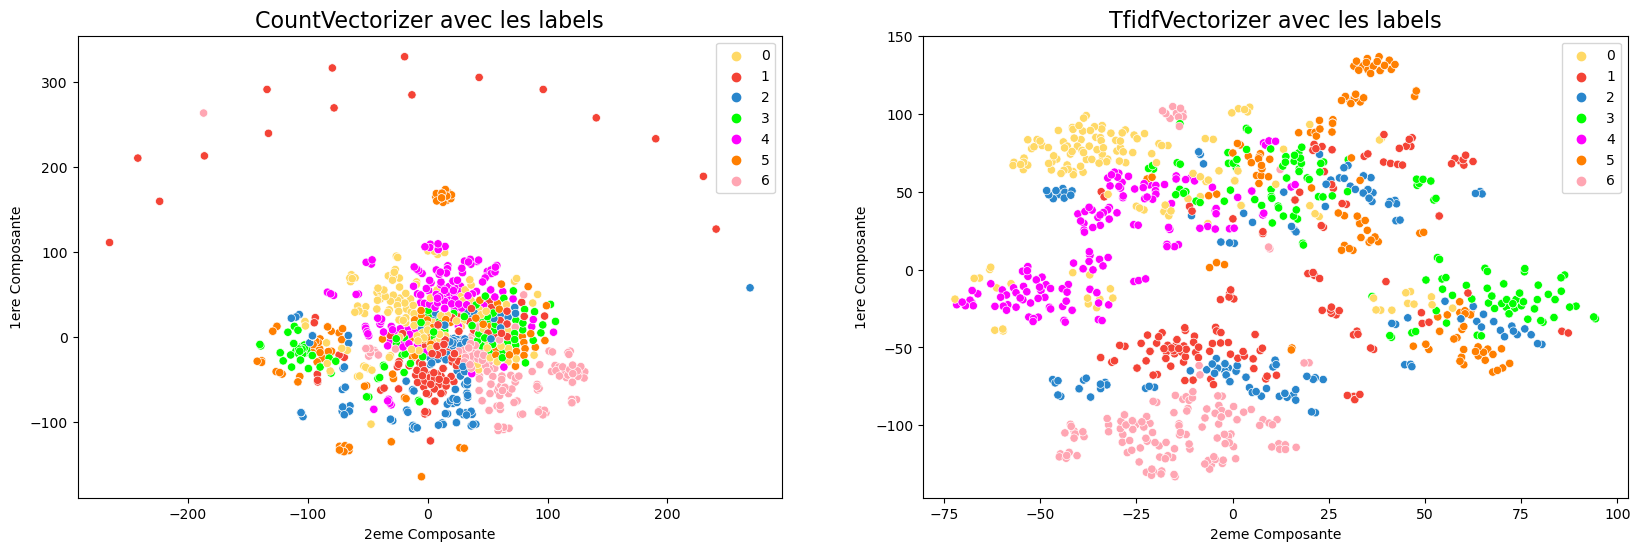

ARI CountVectorizer = 0.16889974333724406
ARI TfidfVectorizer = 0.2949401079288162


In [37]:
#trigrammes
ari_xt = vec_comp(X_b,3)
df_bagn.loc['BoN_wo_sw_tri',:] = ari_xt

#### Avec stemming

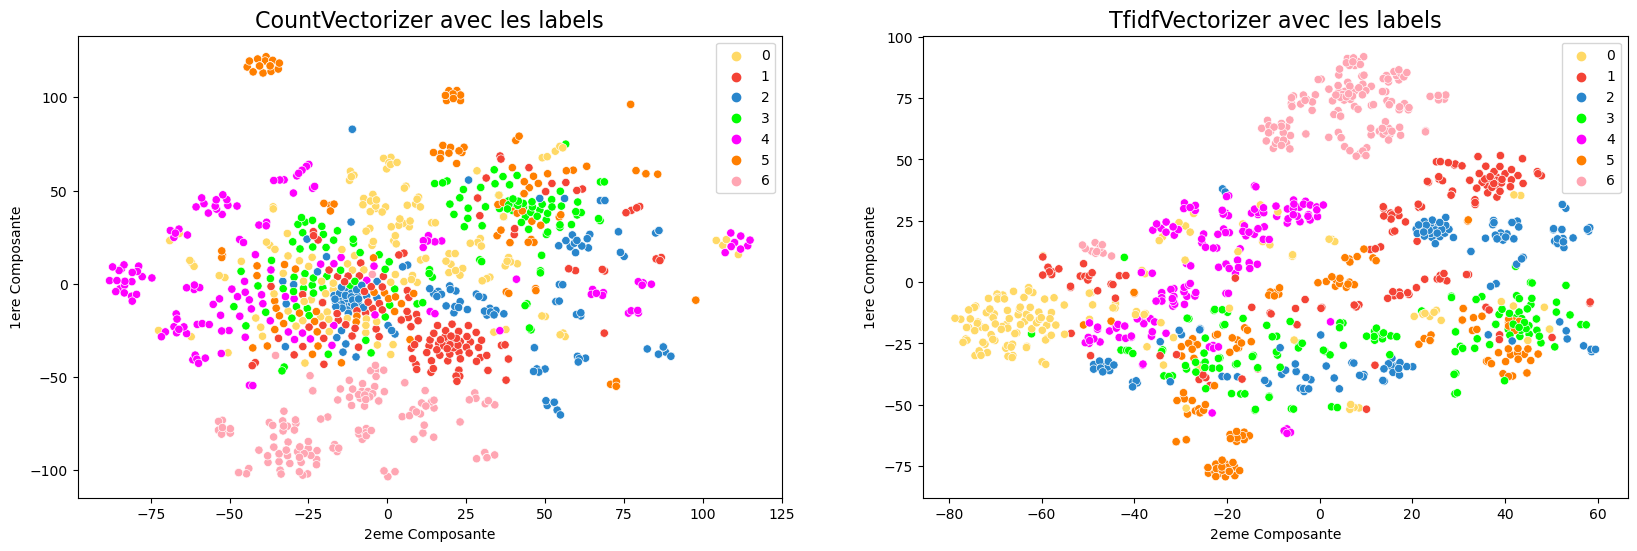

ARI CountVectorizer = 0.2196177483467261
ARI TfidfVectorizer = 0.336687480567


In [38]:
X2_b= df['name_desc_clean_stem']
X2_b.name = 'avec_stemming'

#bigrammes
ari_x2b = vec_comp(X2_b,2)
df_bagn.loc['BoN_stem_bi',:] = ari_x2b

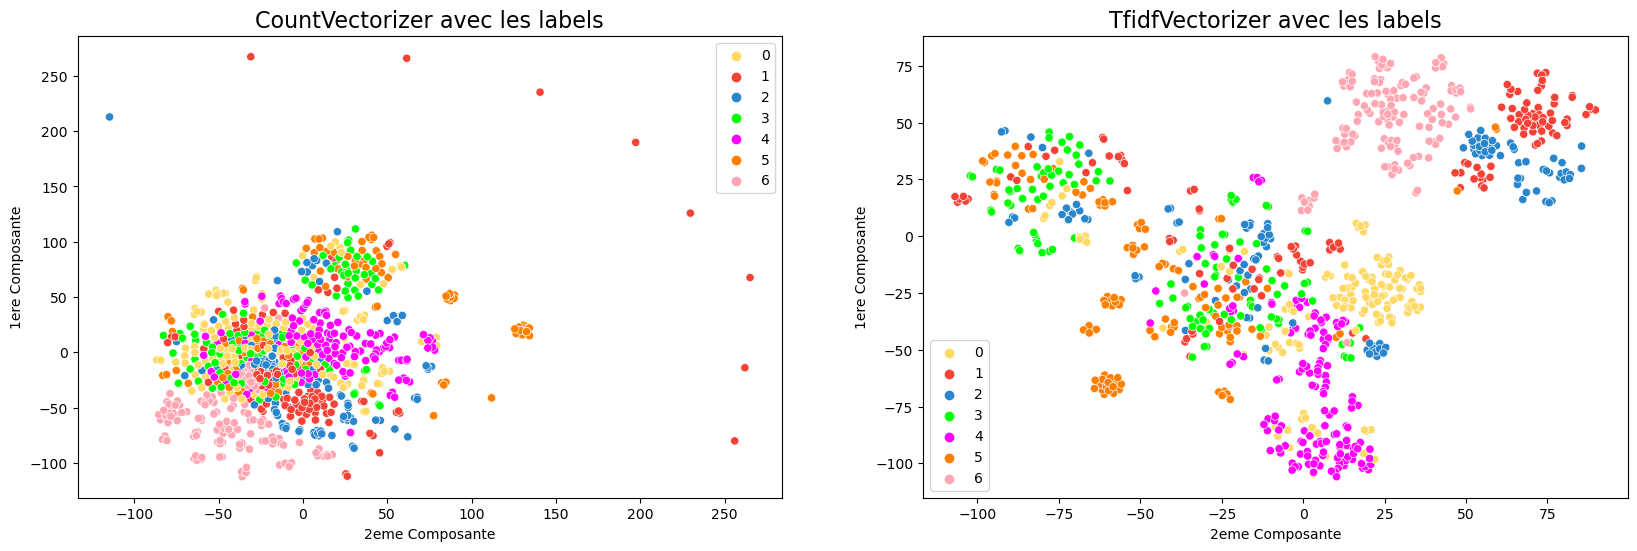

ARI CountVectorizer = 0.16654574454963636
ARI TfidfVectorizer = 0.3523082455335077


In [39]:
#trigrammes
ari_x2t = vec_comp(X2_b,3)
df_bagn.loc['BoN_stem_tri',:] = ari_x2t

#### Avec lemmatisation

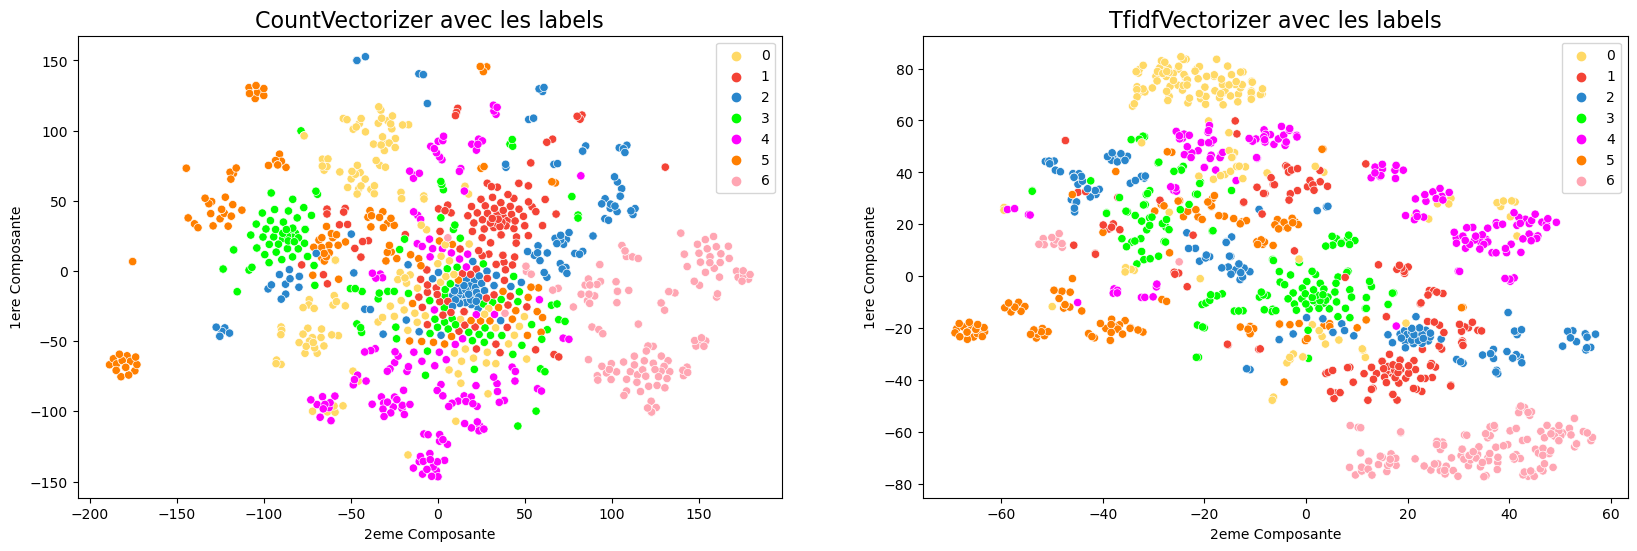

ARI CountVectorizer = 0.2672998234083086
ARI TfidfVectorizer = 0.3531392593727609


In [40]:
X3_b= df['name_desc_clean_lem']
X3_b.name = 'avec_lemmatisation'

#bigrammes
ari_x3b = vec_comp(X3_b,2)
df_bagn.loc['BoN_lem_bi',:] = ari_x3b

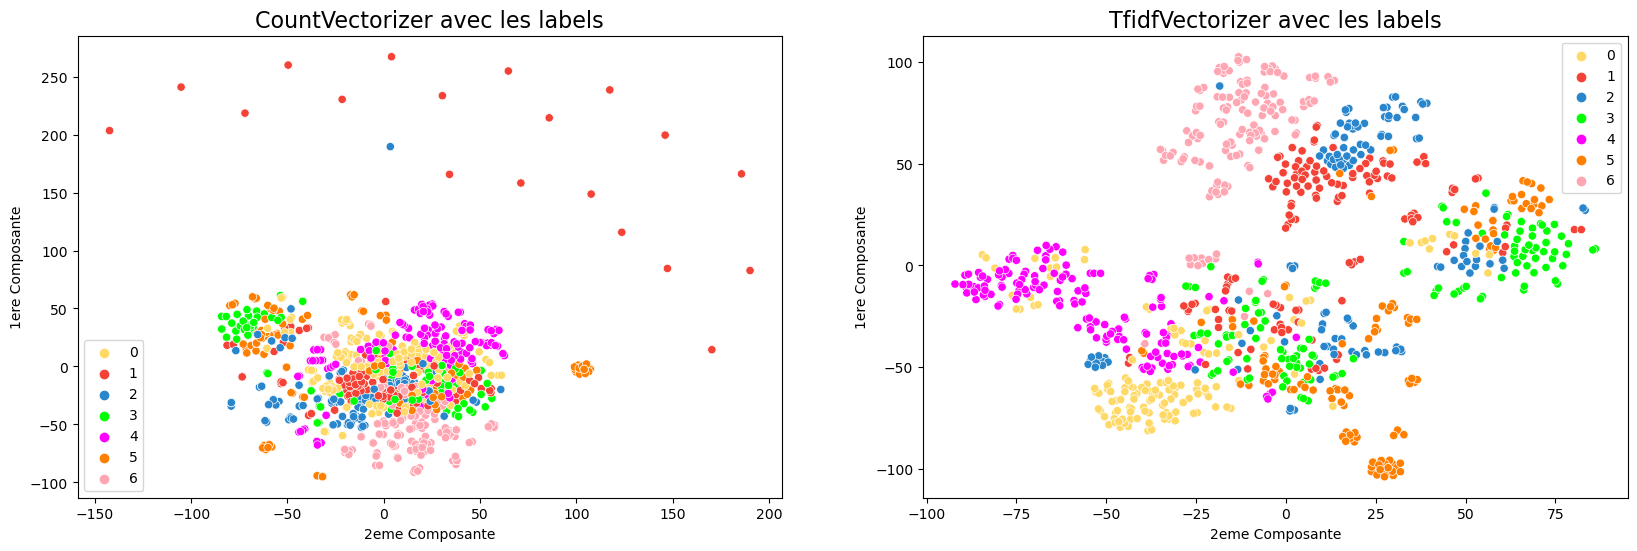

ARI CountVectorizer = 0.16288854169122516
ARI TfidfVectorizer = 0.3357809543335209


In [41]:
#Trigramme
ari_x3t = vec_comp(X3_b,3)
df_bagn.loc['BoN_lem_tri',:] = ari_x3t

In [42]:
df_bagn

ARI_Count ARI_Tfidf
BoN_wo_sw_bi   0.199699  0.330899
BoN_wo_sw_tri    0.1689   0.29494
BoN_stem_bi    0.219618  0.336687
BoN_stem_tri   0.166546  0.352308
BoN_lem_bi       0.2673  0.353139
BoN_lem_tri    0.162889  0.335781

### Topic modelling
- Combinaison de CountVectorizer et LDA 
- Combinaison de TfidVectorizer et NMF

#### Sans stopwords

Mots qui representent les catégories via CountVectorizer et LDA


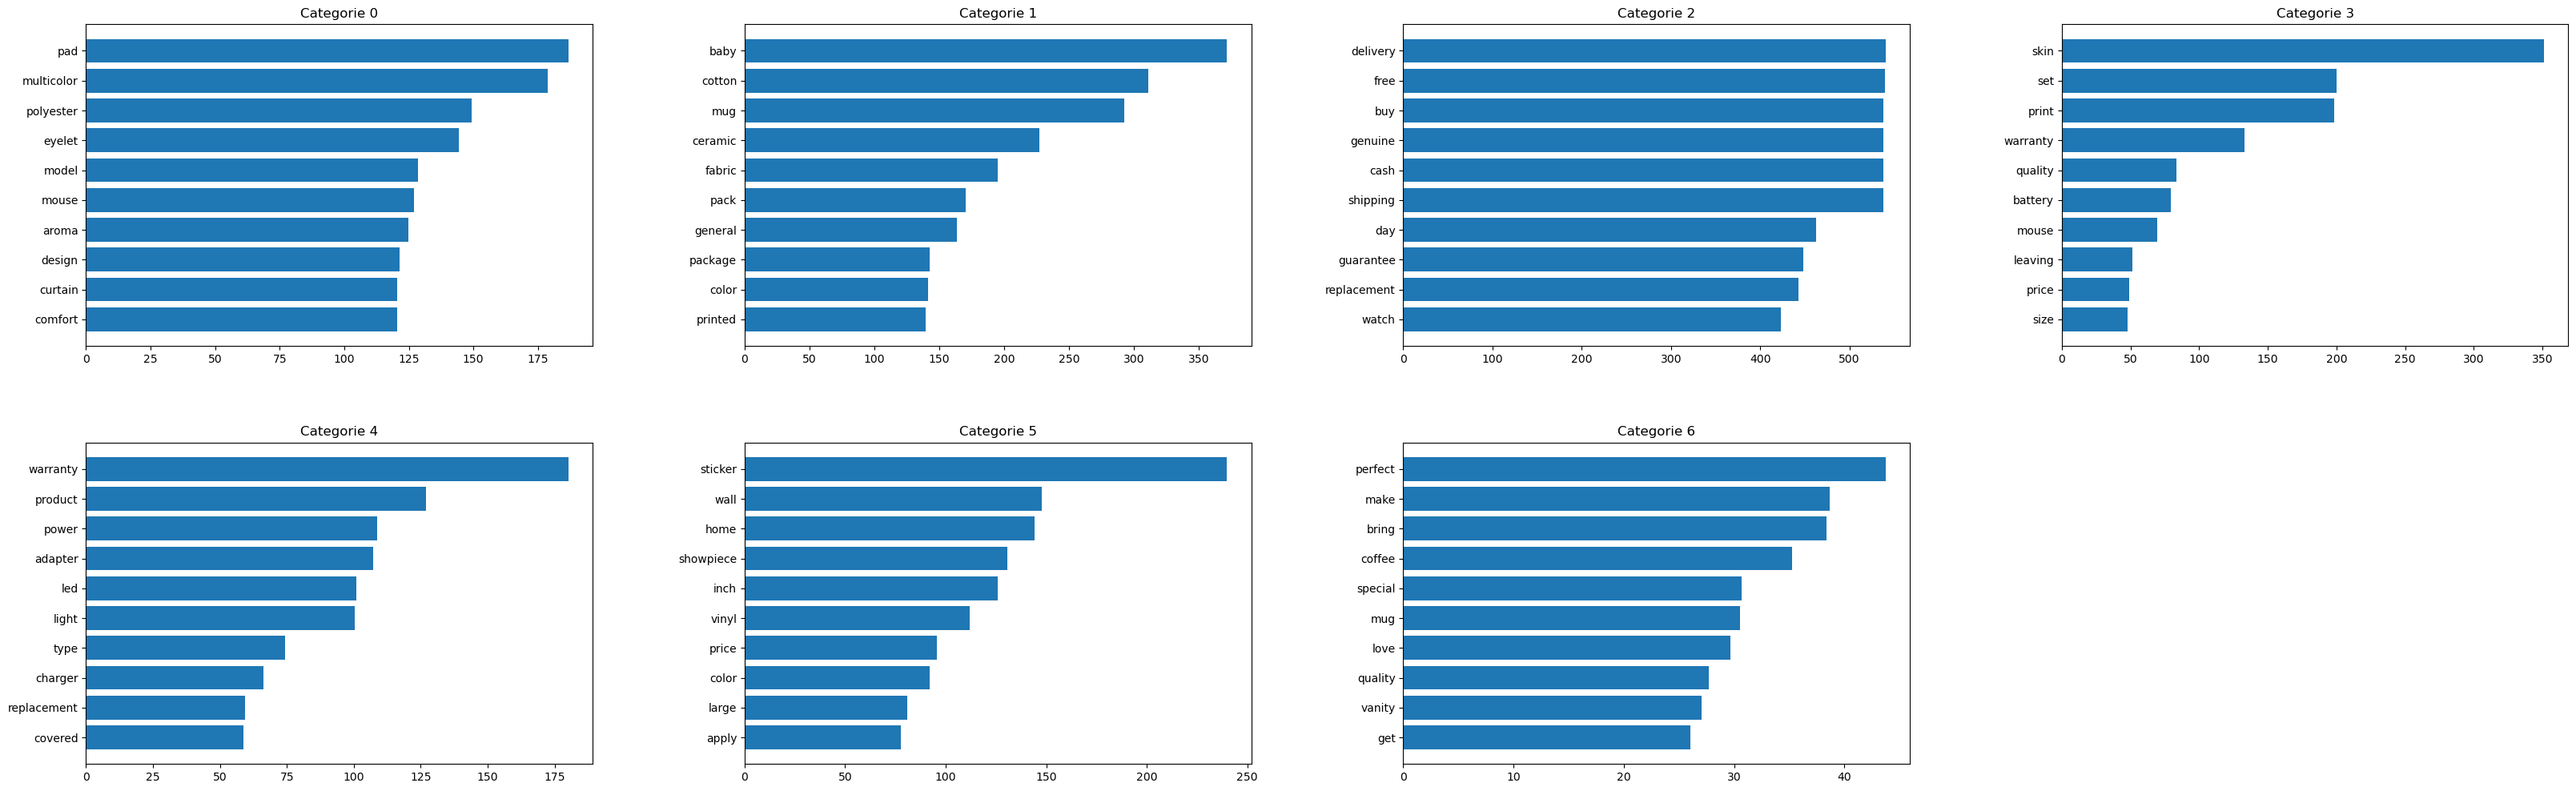



Mots qui representent les catégories via TfidfVectorizer et NMF


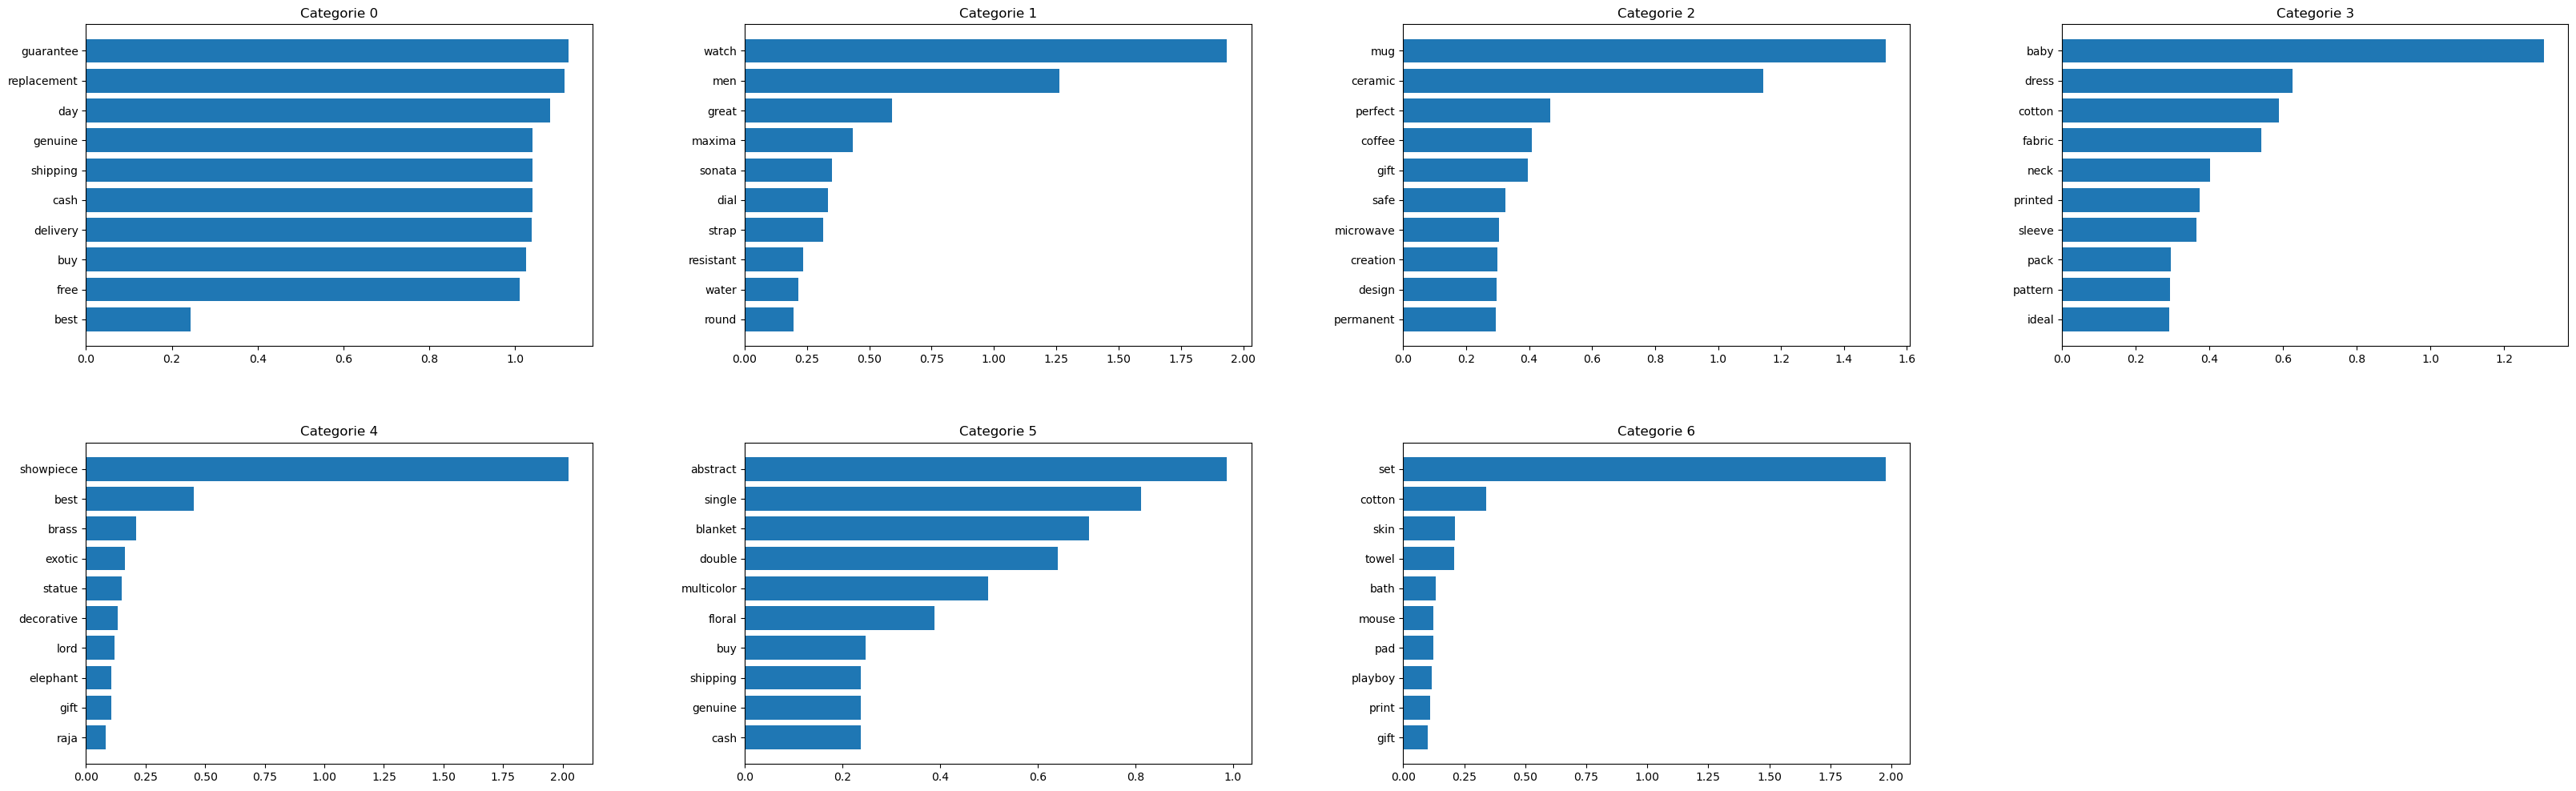

In [43]:
visu_topic(X,7)

#### Avec lemmatisation

Mots qui representent les catégories via CountVectorizer et LDA


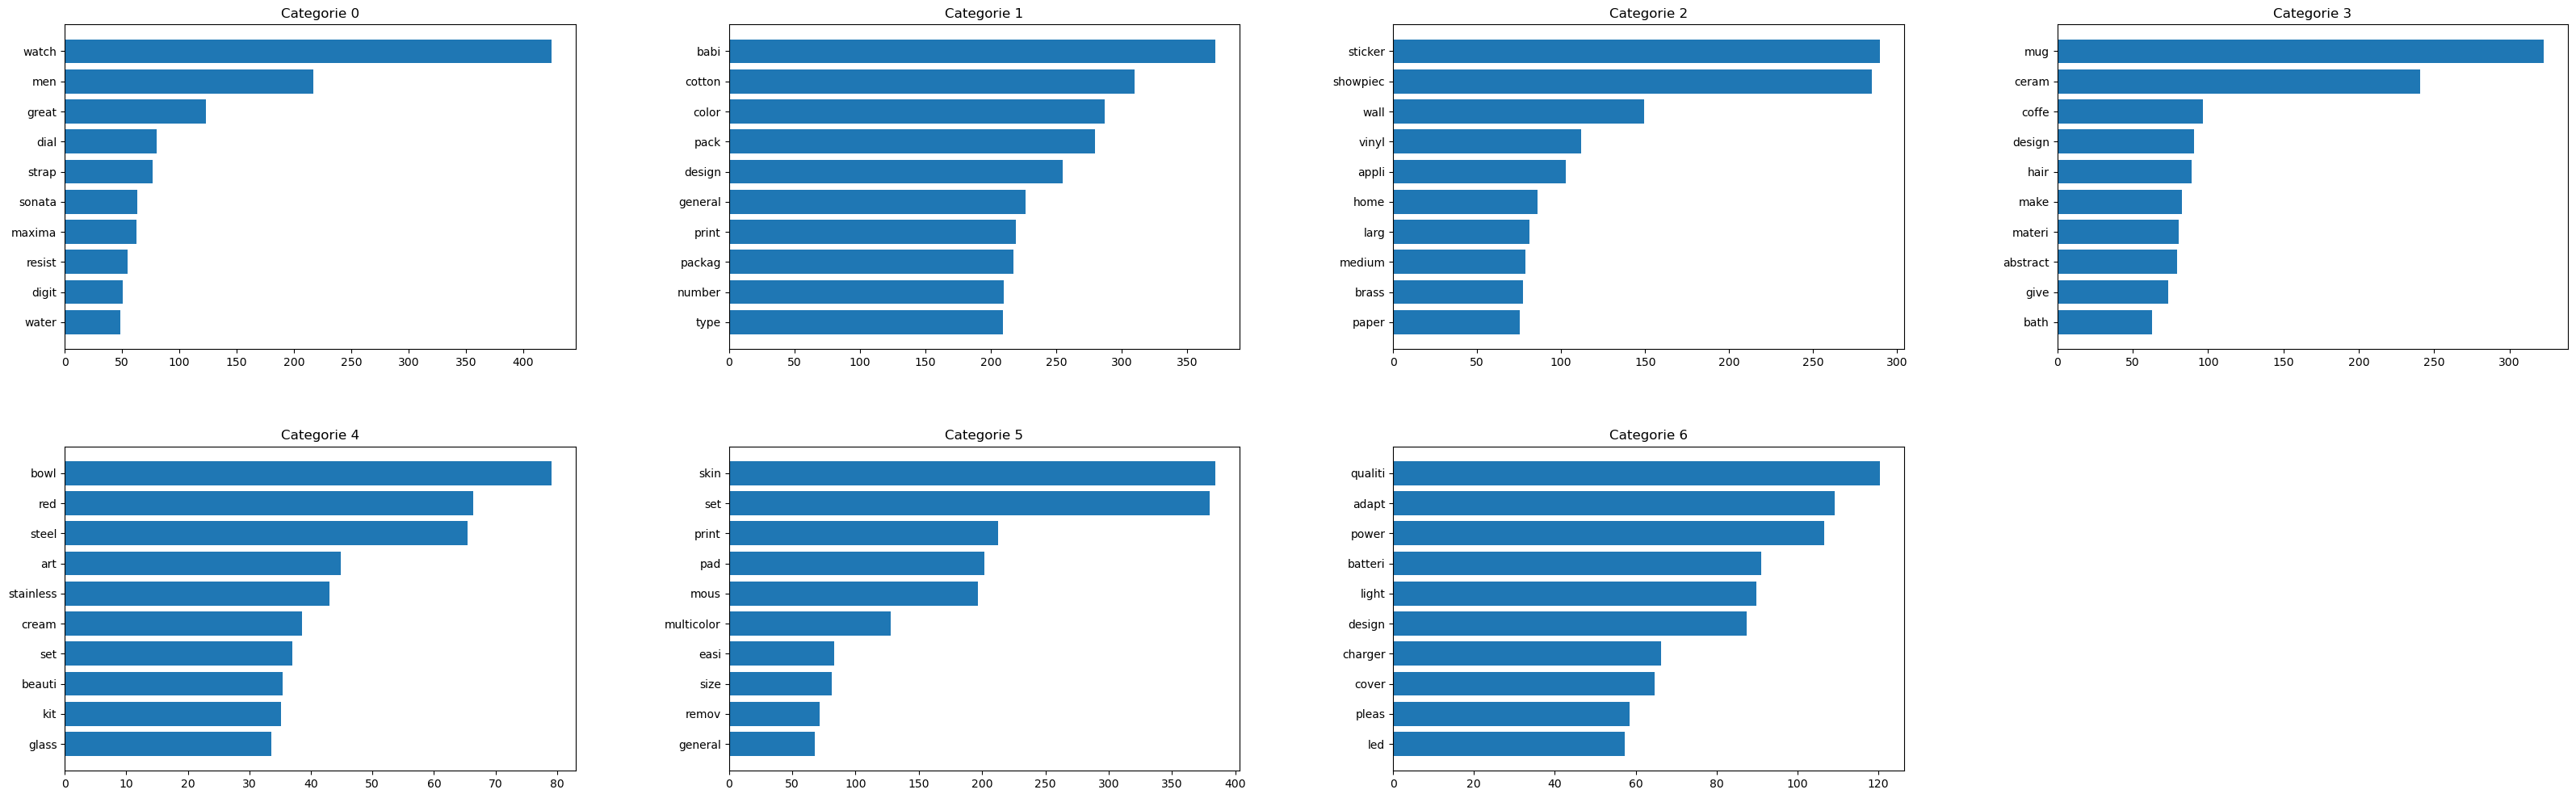



Mots qui representent les catégories via TfidfVectorizer et NMF


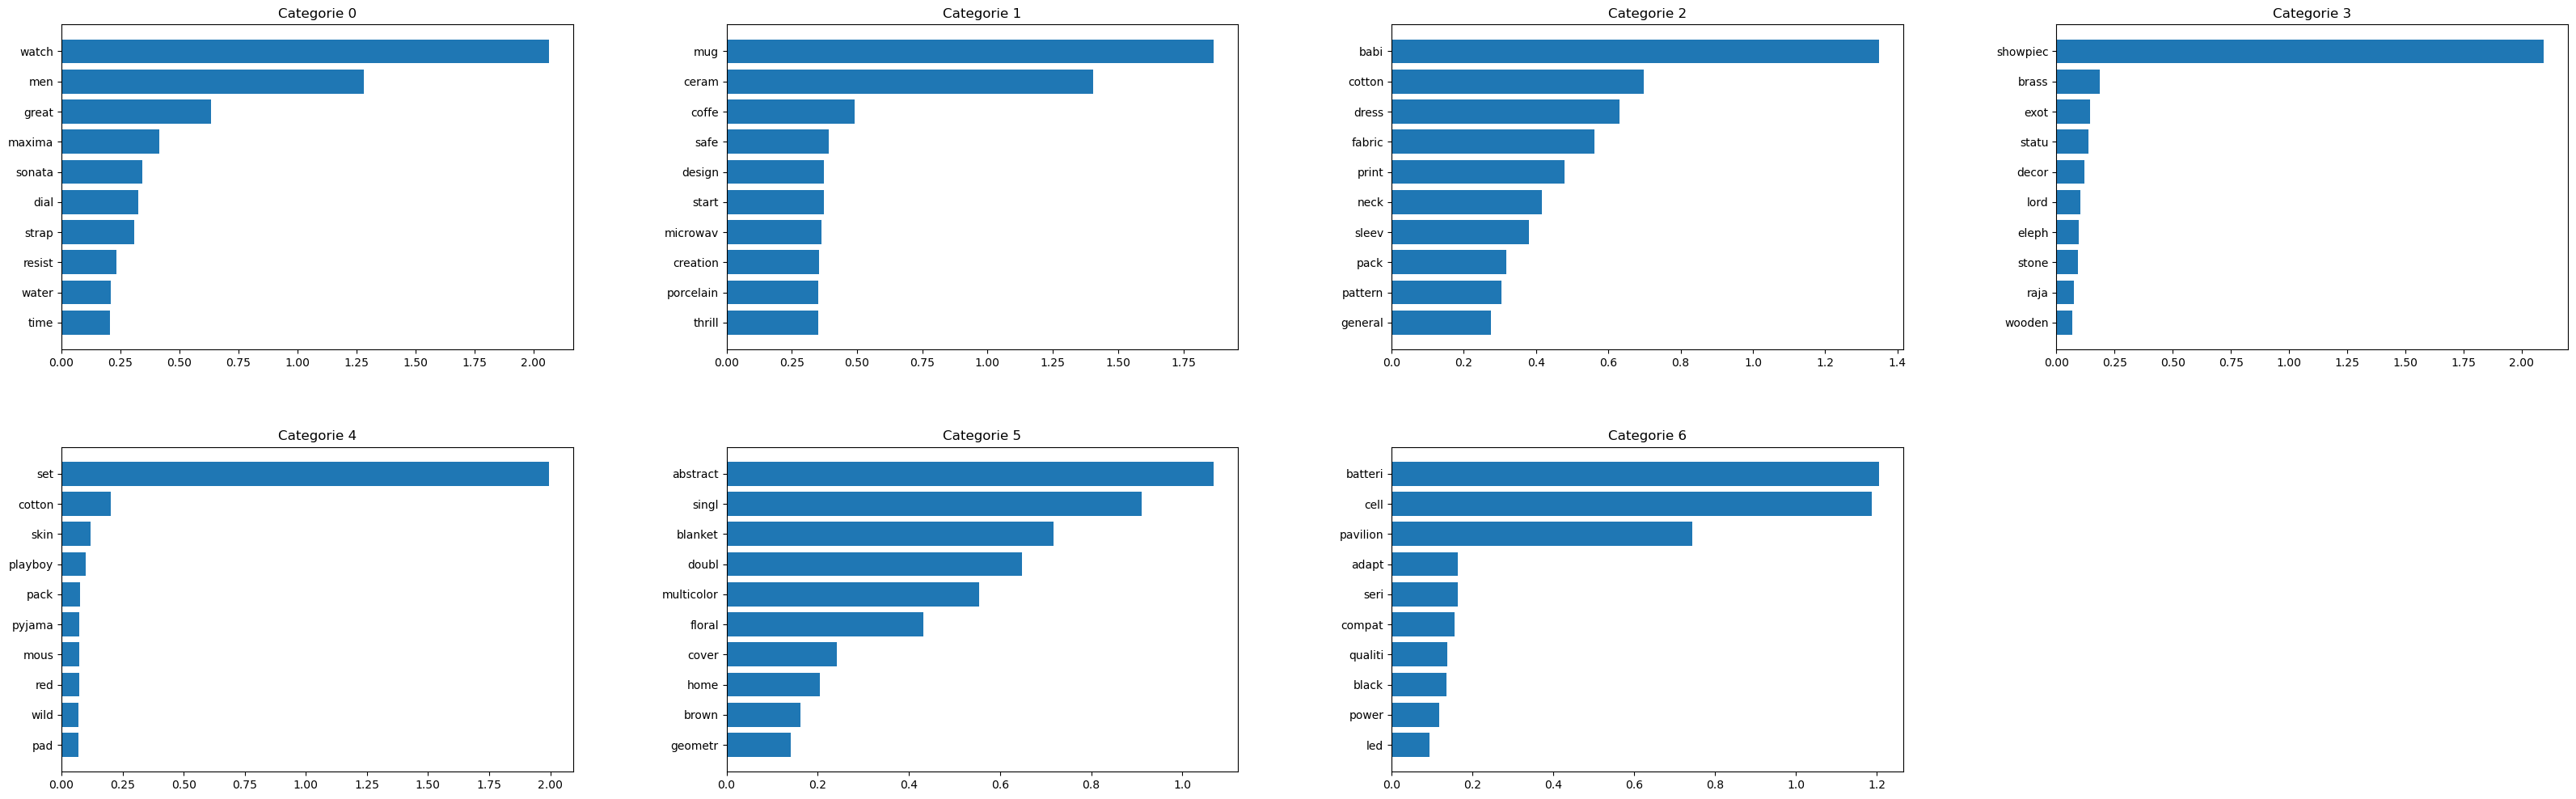

In [44]:
visu_topic(X2,7)

#### Avec stemming

Mots qui representent les catégories via CountVectorizer et LDA


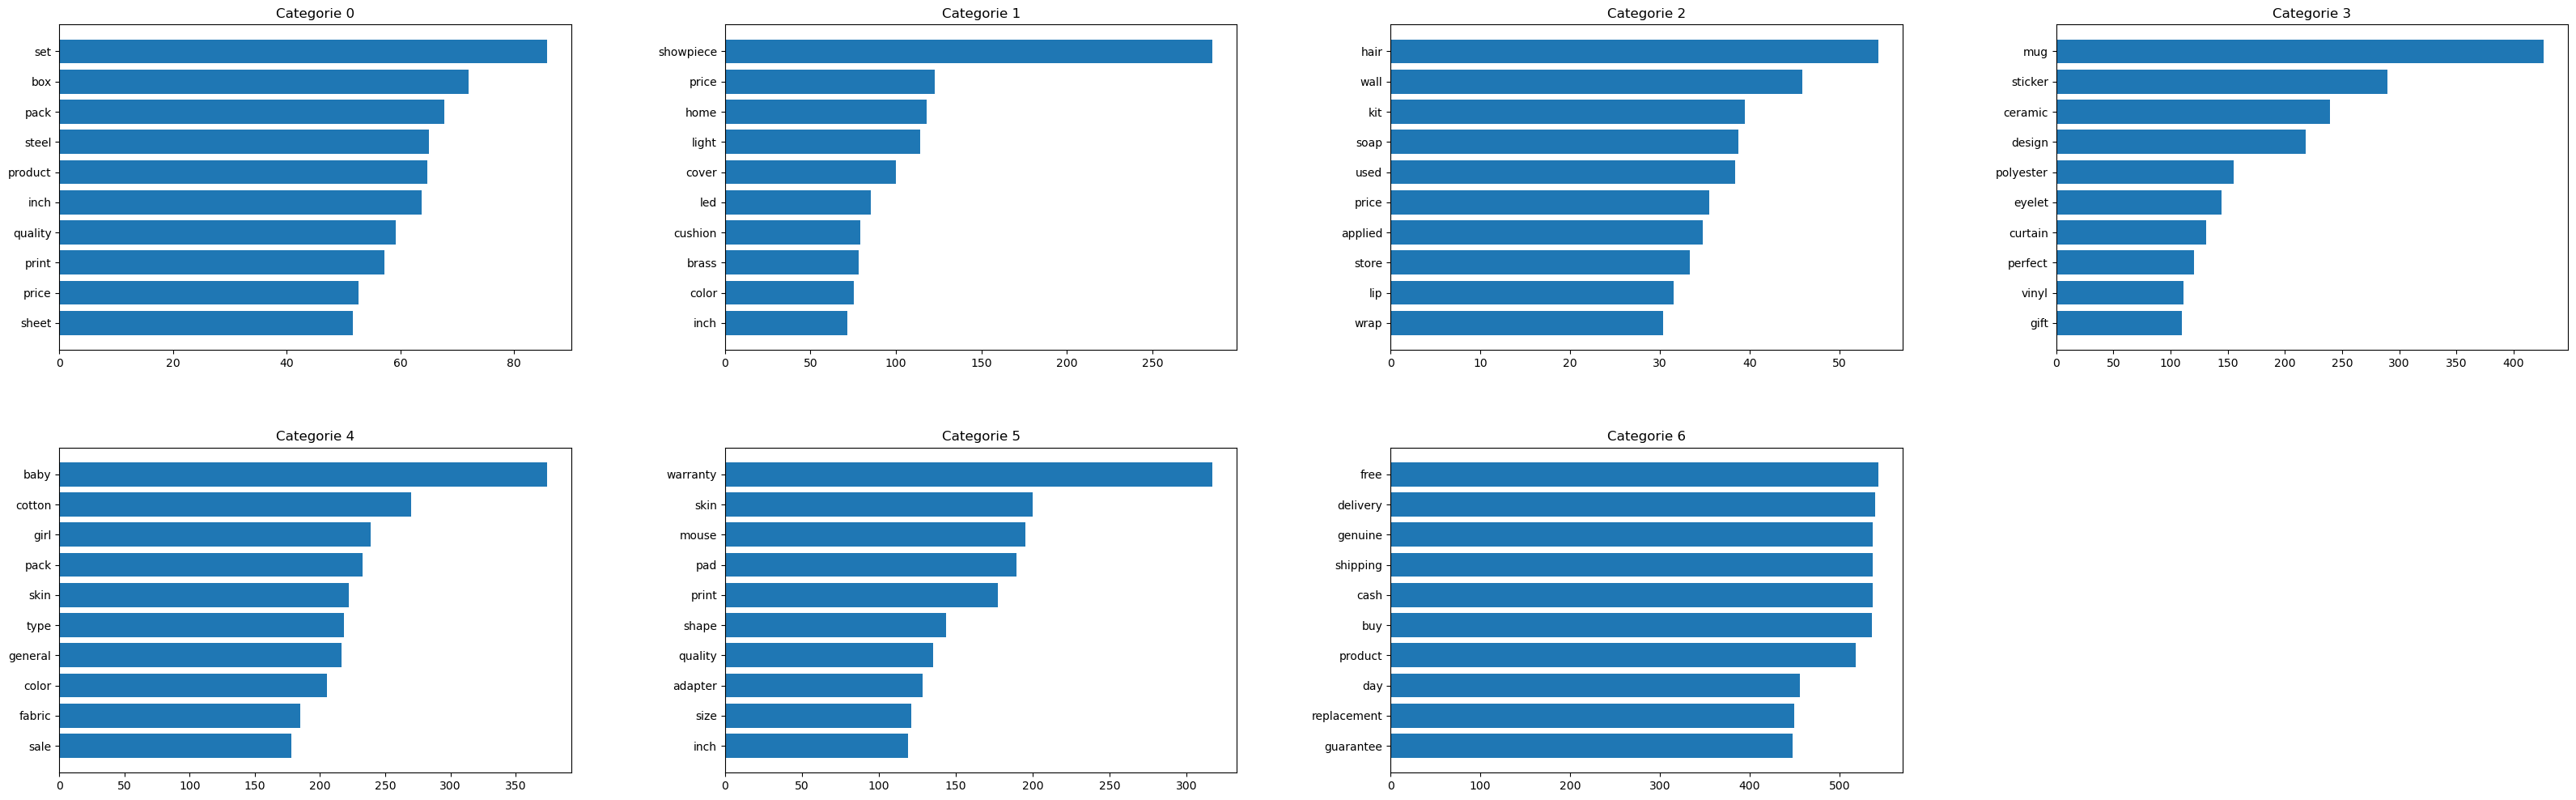



Mots qui representent les catégories via TfidfVectorizer et NMF


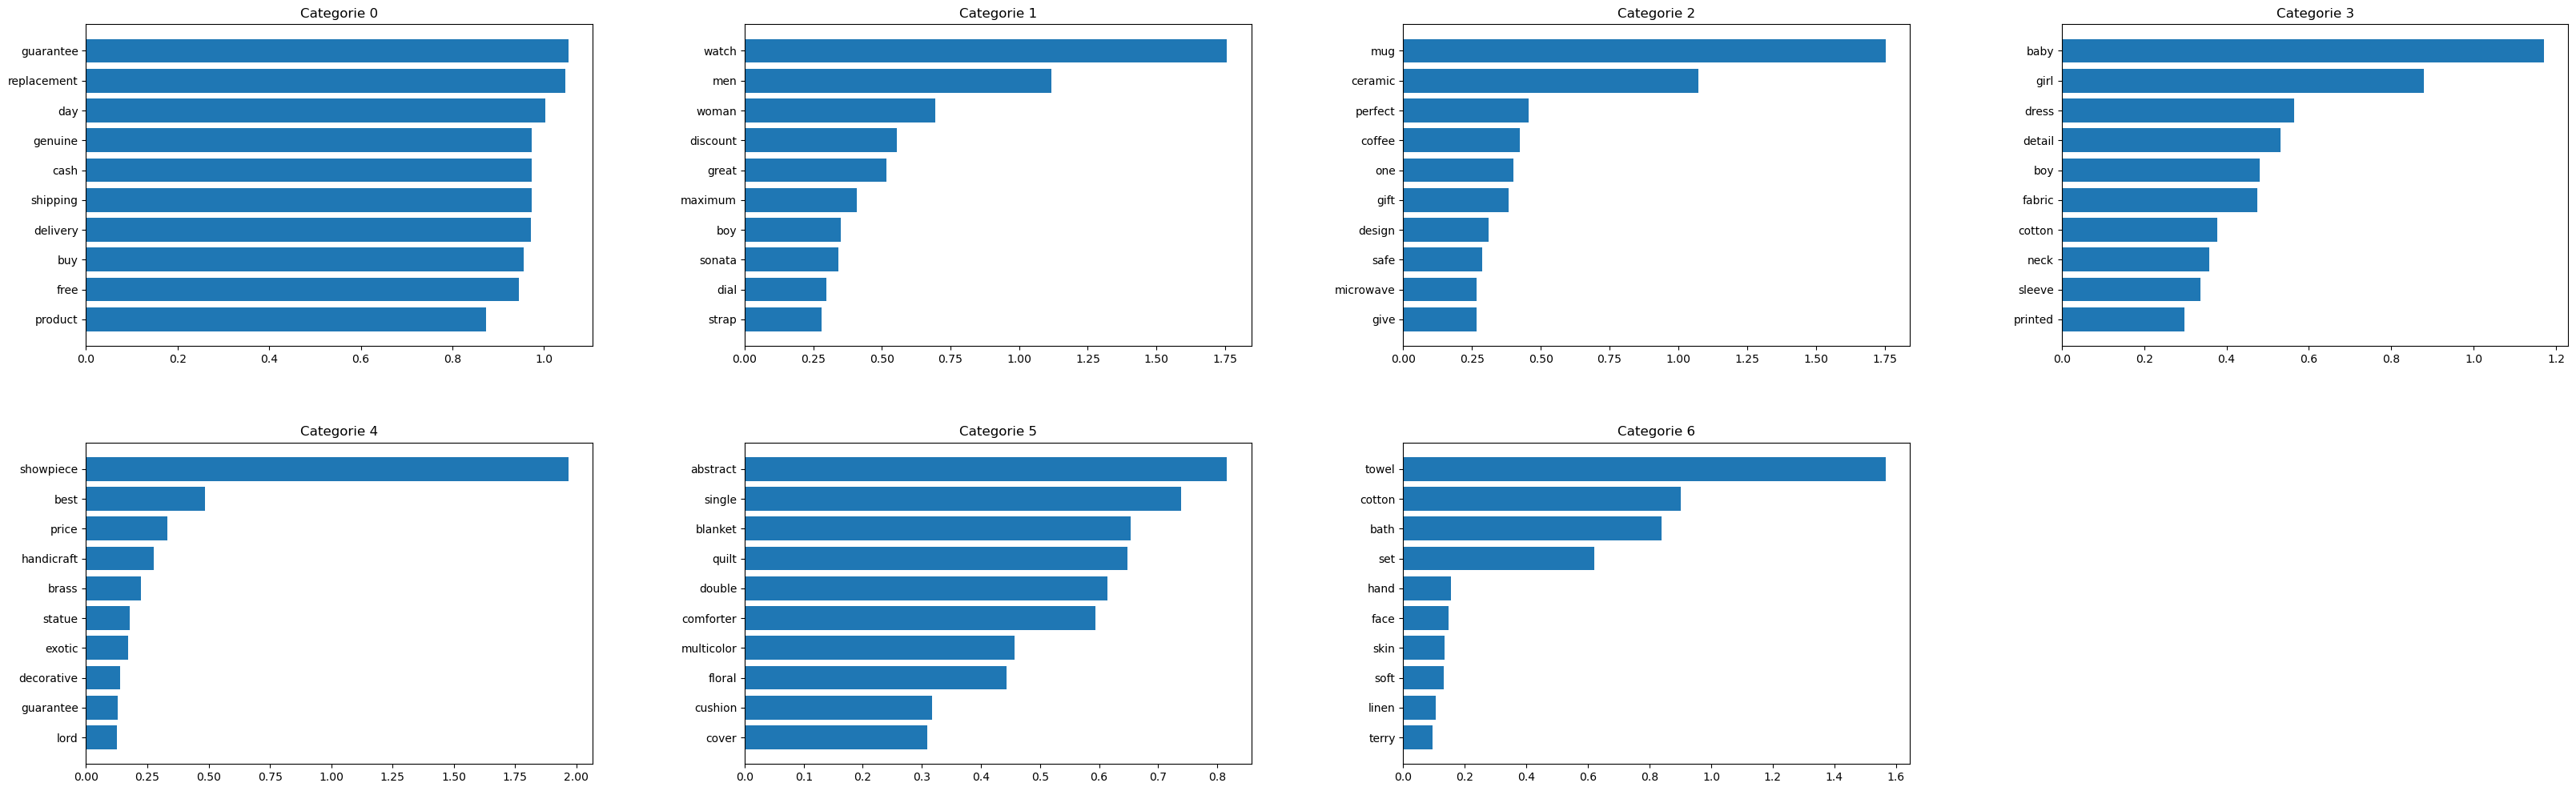

In [45]:
visu_topic(X3,7)

### Classifications via SGDClassifier

Pour la classification, on choisira le pré-traitement réalisé la lemmatisation

In [46]:
#Labelisation
label0 = preprocessing.LabelEncoder()
cat0 = label0.fit_transform(df["main_category"])

# Train Split
Xtrain, Xtest, ytrain, ytest = train_test_split(df['name_desc_clean_lem'], cat0, train_size=0.8)

#### CountVectorizer

In [117]:
start = time.time()

cv_train = CountVectorizer().fit_transform(Xtrain)

# Reduction de dimension
tsvd =TruncatedSVD(n_components = 5)
train_reduced = tsvd.fit_transform(cv_train)


#Recherche des meilleures hyperparamètres
sgdc = linear_model.SGDClassifier()
param = {'loss' : ['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge', 'perceptron', \
                   'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
         'max_iter': [10,100,500,1000,1500], 
         'alpha': [0.0001,0.001,0.01,0.1]}

clf_cv = GridSearchCV(sgdc, param, scoring='accuracy').fit(train_reduced, ytrain)

train_time = (time.time() - start)

In [118]:
clf_cv.best_params_

{'alpha': 0.1, 'loss': 'modified_huber', 'max_iter': 1000}

In [119]:
df_model.loc['CountVectorizer','Train_Time'] = train_time
df_model.loc['CountVectorizer','Train_Accuracy'] = clf_cv.best_score_
clf_cv.best_score_

0.6714285714285715

In [120]:
start = time.time()
cv_test = CountVectorizer().fit_transform(Xtest)
test_reduced = tsvd.fit_transform(cv_test)
lab_cv = clf_cv.predict(test_reduced)
test_time = (time.time() - start)

In [121]:
df_model.loc['CountVectorizer','Test_Time'] = test_time
df_model.loc['CountVectorizer','Test_Accuracy'] = metrics.accuracy_score(ytest, lab_cv)
metrics.accuracy_score(ytest, lab_cv)

0.3142857142857143

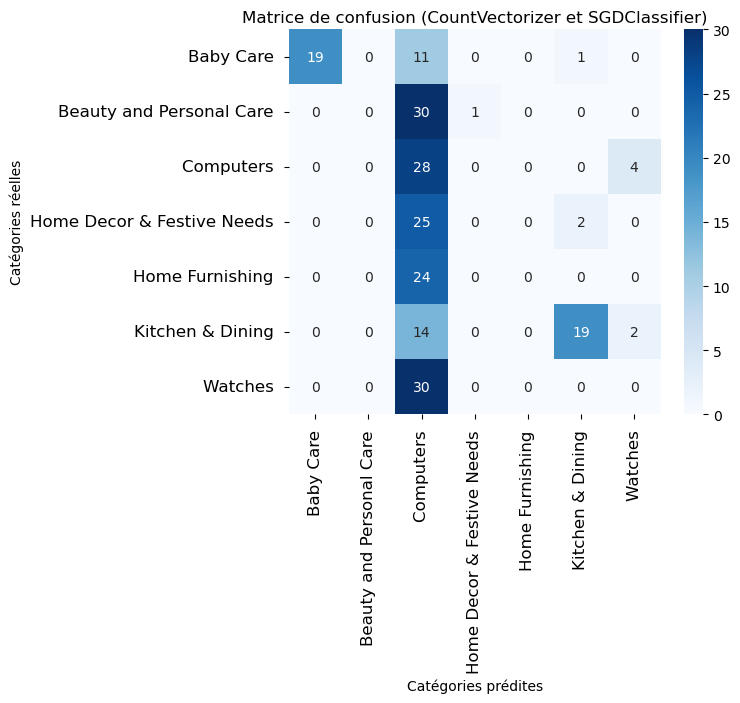

In [122]:
cm_cv  = metrics.confusion_matrix(ytest, lab_cv)
plt.figure( figsize=(6,5))
sns.heatmap(cm_cv, annot=True, cmap='Blues')
plt.xticks(np.arange(0.5, 7.5, 1), label0.classes_, rotation = 90, fontsize=12)
plt.yticks(np.arange(0.5, 7.5, 1), label0.classes_, rotation = 0, fontsize=12)
plt.xlabel('Catégories prédites')
plt.ylabel('Catégories réelles')
plt.title('Matrice de confusion (CountVectorizer et SGDClassifier)')
plt.savefig("./Visualisations/Comparaison/Matrice_de_confusion_CV")
plt.show()

#### TfidfVectorizer

In [123]:
start = time.time()

ctf_train = TfidfVectorizer().fit_transform(Xtrain)
ctf_reduced = tsvd.fit_transform(ctf_train)

#Recherche des meilleures hyperparamètres
clf_ctf = GridSearchCV(sgdc, param, scoring='accuracy').fit(ctf_reduced, ytrain)

train_time = (time.time() - start)

In [124]:
clf_ctf.best_params_

{'alpha': 0.001, 'loss': 'squared_hinge', 'max_iter': 1500}

In [125]:
df_model.loc['TfidfVectorizer','Train_Time'] = train_time
df_model.loc['TfidfVectorizer','Train_Accuracy'] = clf_ctf.best_score_
clf_cv.best_score_

0.6714285714285715

In [126]:
start = time.time()
ctf_test = TfidfVectorizer().fit_transform(Xtest)
test1_reduced = tsvd.fit_transform(ctf_test)
lab_ctf = clf_ctf.predict(test1_reduced)
test_time = (time.time() - start)

In [127]:
df_model.loc['TfidfVectorizer','Test_Time'] = test_time
df_model.loc['TfidfVectorizer','Test_Accuracy'] = metrics.accuracy_score(ytest, lab_ctf)
metrics.accuracy_score(ytest, lab_ctf)

0.11428571428571428

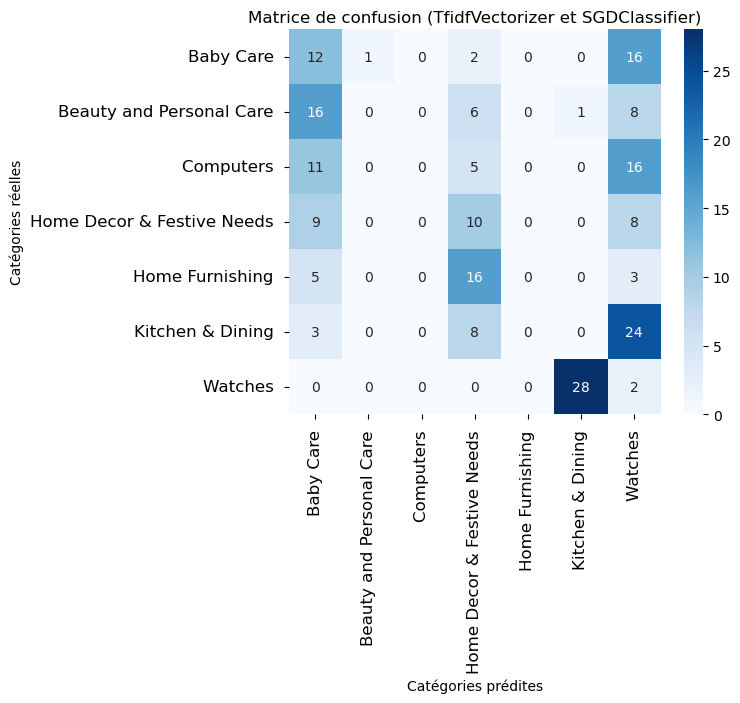

In [128]:
cm_ctf  = metrics.confusion_matrix(ytest, lab_ctf)
plt.figure( figsize=(6,5))
sns.heatmap(cm_ctf, annot=True, cmap='Blues')
plt.xticks(np.arange(0.5, 7.5, 1), label0.classes_, rotation = 90, fontsize=12)
plt.yticks(np.arange(0.5, 7.5, 1), label0.classes_, rotation = 0, fontsize=12)
plt.xlabel('Catégories prédites')
plt.ylabel('Catégories réelles')
plt.title('Matrice de confusion (TfidfVectorizer et SGDClassifier)')
plt.savefig("./Visualisations/Comparaison/Matrice_de_confusion_TFIDF")
plt.show()

## Word/Sentence Embledding

In [59]:
#Observations du nombre de threads
print("Nombre de threads:", multiprocessing.cpu_count())

Nombre de threads: 12


### Doc2Vec
- Test via un modèle d'apprentissage non supervisé
- Test via un modèle de classification

In [60]:
descrip = df['name_desc_clean_lem'].to_list()
#Tokanisation
descrip = [gensim.utils.simple_preprocess(text) for text in descrip]
#tagger les documents
descripTag = [TaggedDocument(doc, [i]) for i, doc in enumerate(descrip)]
#Comptage des longueurs des phrases
count_len = [len(text) for text in descrip]
print('Longueur max des descriptions :', max(count_len))

Longueur max des descriptions : 329


In [61]:
model = Doc2Vec(descripTag, 
                vector_size=400, 
                window=2, 
                min_count=2)

In [62]:
#Construction du dictionnaire
model.build_vocab(descripTag)

In [63]:
model.train(descripTag, total_examples=model.corpus_count, epochs=100)

In [64]:
model.wv.most_similar(positive=['beauty'])

[('beat', 0.6641378998756409),
 ('extensive', 0.6612052321434021),
 ('given', 0.6100530028343201),
 ('timepiece', 0.5806384086608887),
 ('mango', 0.5687776207923889),
 ('built', 0.5669936537742615),
 ('grace', 0.5593226552009583),
 ('scrubber', 0.5549361705780029),
 ('selection', 0.5448323488235474),
 ('heritage', 0.5403030514717102)]

In [65]:
model.dv.vectors.shape

(1050, 400)

#### k-Means et T-SNE

In [66]:
label1 = preprocessing.LabelEncoder()
cat = label1.fit_transform(df["main_category"])

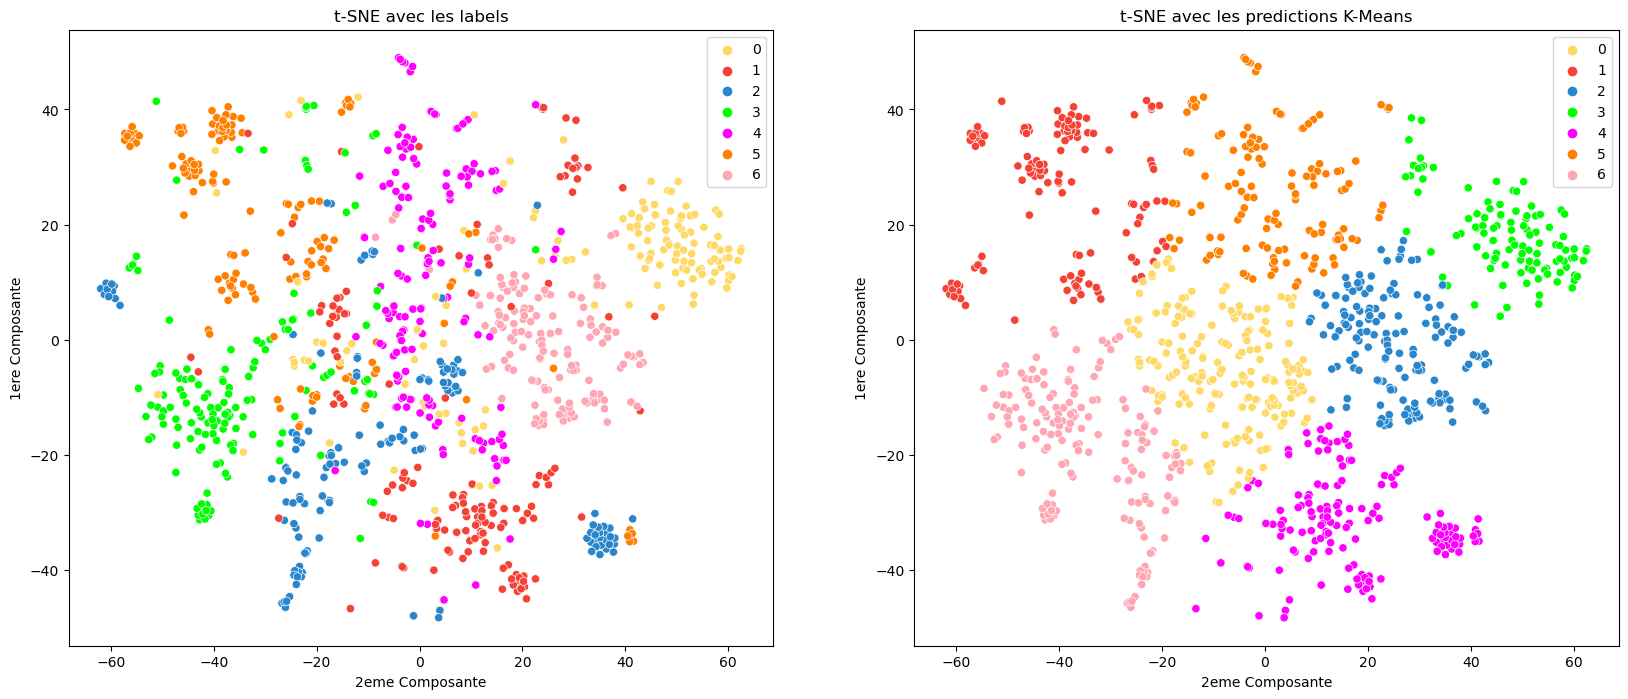

0.34624005519589884


In [67]:
tsne = manifold.TSNE(n_components=2, perplexity=20, n_iter=5000, init="random")
w2v_tsne = tsne.fit_transform(model.dv.vectors)
cls_w2v = cluster.KMeans(n_clusters=7).fit(w2v_tsne)
lab_w2v = cls_w2v.labels_

#Visualisation
colors=['#ffd966', '#f44336', '#2986cc', '#00FF00', '#FF00FF', '#ff7f00', "#ffa6b3"]
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.scatterplot(x=  w2v_tsne[:,1], y= w2v_tsne[:,0], hue=cat, palette=colors)
plt.xlabel("2eme Composante")
plt.ylabel("1ere Composante")
plt.title("t-SNE avec les labels")
plt.subplot(1,2,2)
sns.scatterplot(x=  w2v_tsne[:,1], y= w2v_tsne[:,0], hue=lab_w2v, palette=colors)
plt.xlabel("2eme Composante")
plt.ylabel("1ere Composante")
plt.title("t-SNE avec les predictions K-Means")
plt.show()

print(metrics.adjusted_rand_score(cat, lab_w2v))

#### SGDClassifer 

In [68]:
# Train Split
X_train, X_test, y_train, y_test = train_test_split(df['name_desc_clean_lem_2'], cat, train_size=0.8)

In [69]:
start = time.time()

descrip2 = X_train.to_list()
#Tokanisation
descrip2 = [gensim.utils.simple_preprocess(text) for text in descrip2]
#tagger les documents
descripTag2 = [TaggedDocument(doc, [i]) for i, doc in enumerate(descrip2)]
#Comptage des longueurs des phrases
count_len = [len(text) for text in descrip2]
print('Longueur max des descriptions :', max(count_len))

Longueur max des descriptions : 207


In [70]:
#Paramètres Doc2vec
model2 = Doc2Vec(descripTag2, 
                vector_size=300, #Taille des vecteurs
                window=2, #nombre de voisins
                min_count=2) 

#Construction du dictionnaire
model2.build_vocab(descripTag2)

#Entrainement du model
model2.train(descripTag2, total_examples=model2.corpus_count, epochs=100)

print('Dimension matrice de sortie:', model2.dv.vectors.shape)

Dimension matrice de sortie: (840, 300)


In [71]:
sgdc = linear_model.SGDClassifier()
param = {'loss' : ['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge', 'perceptron', \
                   'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
         'max_iter': [10,100,500,1000,1500], 
         'alpha': [0.0001,0.001,0.01,0.1]}

clf = GridSearchCV(sgdc, param).fit(model2.dv.vectors,y_train)

train_time = (time.time() - start)

In [72]:
clf.best_params_

{'alpha': 0.01, 'loss': 'modified_huber', 'max_iter': 1500}

In [73]:
clf.best_score_

0.8214285714285714

In [74]:
df_model.loc['Doc2Vec','Train_Time'] = train_time
df_model.loc['Doc2Vec','Train_Accuracy'] = clf.best_score_

In [75]:
# test des les plus similaires du mots 'baby'
model2.wv.most_similar(positive=['baby'])

[('next', 0.6364794373512268),
 ('dress', 0.6303213834762573),
 ('got', 0.6227915287017822),
 ('romper', 0.6191100478172302),
 ('striped', 0.6077103018760681),
 ('empire', 0.6027534008026123),
 ('waist', 0.5975154042243958),
 ('trouser', 0.5969619750976562),
 ('raglan', 0.5837306380271912),
 ('plan', 0.5729008913040161)]

In [76]:
start = time.time()

descrip3 = X_test.to_list()
#Tokanisation
descrip3 = [gensim.utils.simple_preprocess(text) for text in descrip3]

In [77]:
X = []
for d in descrip3:
    X.append( model2.infer_vector(d) )

In [78]:
df_X = pd.DataFrame(X)

In [79]:
lab_2 = clf.predict(df_X)
test_time = (time.time() - start)

In [80]:
df_model.loc['Doc2Vec','Test_Time'] = test_time
df_model.loc['Doc2Vec','Test_Accuracy'] = metrics.accuracy_score(y_test, lab_2)
metrics.accuracy_score(y_test, lab_2)

0.6666666666666666

In [81]:
label1.classes_

array(['Baby Care ', 'Beauty and Personal Care ', 'Computers ',
       'Home Decor & Festive Needs ', 'Home Furnishing ',
       'Kitchen & Dining ', 'Watches '], dtype=object)

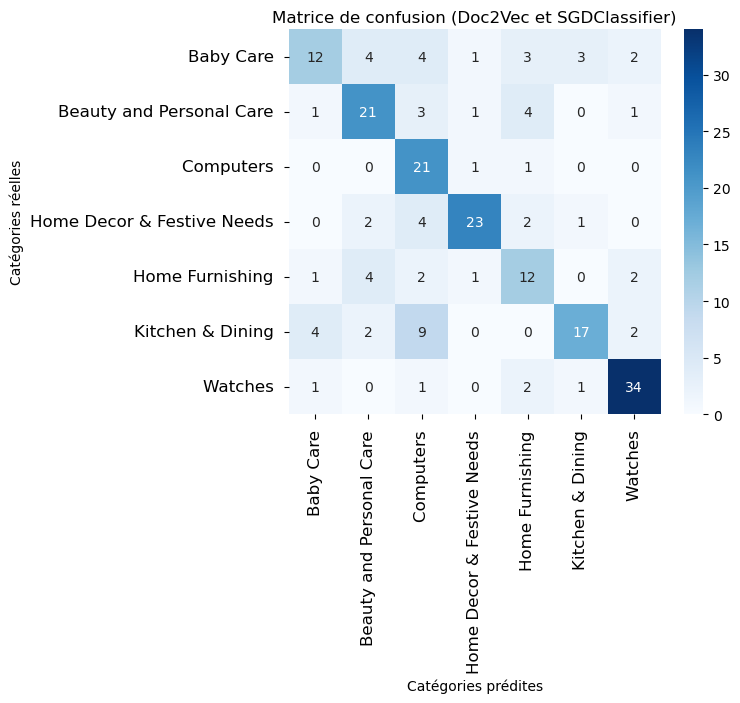

In [82]:
cm_d2v  = metrics.confusion_matrix(y_test, lab_2)
plt.figure( figsize=(6,5))
sns.heatmap(cm_d2v, annot=True, cmap='Blues')
plt.xticks(np.arange(0.5, 7.5, 1), label1.classes_, rotation = 90, fontsize=12)
plt.yticks(np.arange(0.5, 7.5, 1), label1.classes_, rotation = 0, fontsize=12)
plt.xlabel('Catégories prédites')
plt.ylabel('Catégories réelles')
plt.title('Matrice de confusion (Doc2Vec et SGDClassifier)')
plt.savefig("./Visualisations/Comparaison/Matrice_de_confusion_Doc2Vec")
plt.show()

In [83]:
print("Recall :{:.2f}".format(metrics.recall_score(y_test, lab_2, average='micro')))
print("Precision: {:.2f}".format(metrics.precision_score(y_test, lab_2, average='micro')))
print("Accuracy:{:.2f}".format(metrics.accuracy_score(y_test, lab_2)))

Recall :0.67
Precision: 0.67
Accuracy:0.67


## BERT 

In [84]:
import tensorflow_hub as hub

#import
url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(url, trainable=True)

In [85]:
from bert import tokenization
tf.gfile = tf.io.gfile

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [86]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [87]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    clf_output = sequence_output[:, 0, :]
    
    lay = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    lay = tf.keras.layers.Dense(32, activation='relu')(lay)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    out = tf.keras.layers.Dense(7, activation='softmax')(lay)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [88]:
from keras.utils import to_categorical

# Train Split
label = preprocessing.LabelEncoder()
y = label.fit_transform(df['main_category'])
y = to_categorical(y)

train_data, test_data, train_labels, test_labels = train_test_split(df, y, train_size=0.8)

In [89]:
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

max_len = 250
train_input = bert_encode(train_data.name_desc.values, tokenizer, max_len=max_len)
test_input = bert_encode(test_data.name_desc.values, tokenizer, max_len=max_len)

In [90]:
model_bert = build_model(bert_layer, max_len=max_len)
model_bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 250)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 250)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 250)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 250, 768)]                'input_mask[0][0]',         

In [91]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1, verbose=1)

In [92]:
start = time.time()

train_sh = model_bert.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=5,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1)

train_time = (time.time() - start)

Epoch 1/5
21/21 [==============================] - ETA: 0s - loss: 1.8322 - accuracy: 0.2872  
Epoch 1: val_accuracy improved from -inf to 0.51190, saving model to model.h5
21/21 [==============================] - 1394s 65s/step - loss: 1.8322 - accuracy: 0.2872 - val_loss: 1.4522 - val_accuracy: 0.5119
Epoch 2/5
21/21 [==============================] - ETA: 0s - loss: 1.2636 - accuracy: 0.5536  
Epoch 2: val_accuracy improved from 0.51190 to 0.82143, saving model to model.h5
21/21 [==============================] - 1772s 85s/step - loss: 1.2636 - accuracy: 0.5536 - val_loss: 0.7865 - val_accuracy: 0.8214
Epoch 3/5
21/21 [==============================] - ETA: 0s - loss: 0.7662 - accuracy: 0.7381  
Epoch 3: val_accuracy improved from 0.82143 to 0.87500, saving model to model.h5
21/21 [==============================] - 1534s 73s/step - loss: 0.7662 - accuracy: 0.7381 - val_loss: 0.4502 - val_accuracy: 0.8750
Epoch 4/5
21/21 [==============================] - ETA: 0s - loss: 0.5035 - acc

In [93]:
df_model.loc['BERT','Train_Time'] = train_time
df_model.loc['BERT','Train_Accuracy'] = max(train_sh.history['accuracy'])

In [94]:
start = time.time()
out_bert = model_bert.predict(test_input)
test_time = (time.time() - start)

7/7 [==============================] - 59s 8s/step


In [95]:
#model_bert.save('bert_model')

In [96]:
out_lab = [np.argmax(out) for out in out_bert]
test_lab = [np.argmax(out) for out in test_labels]

In [97]:
df_model.loc['BERT','Test_Time'] = test_time
df_model.loc['BERT','Test_Accuracy'] = (metrics.accuracy_score(test_lab, out_lab))

In [98]:
vis = test_input[0]

In [99]:
vis.shape

(210, 250)

In [100]:
label.classes_

array(['Baby Care ', 'Beauty and Personal Care ', 'Computers ',
       'Home Decor & Festive Needs ', 'Home Furnishing ',
       'Kitchen & Dining ', 'Watches '], dtype=object)

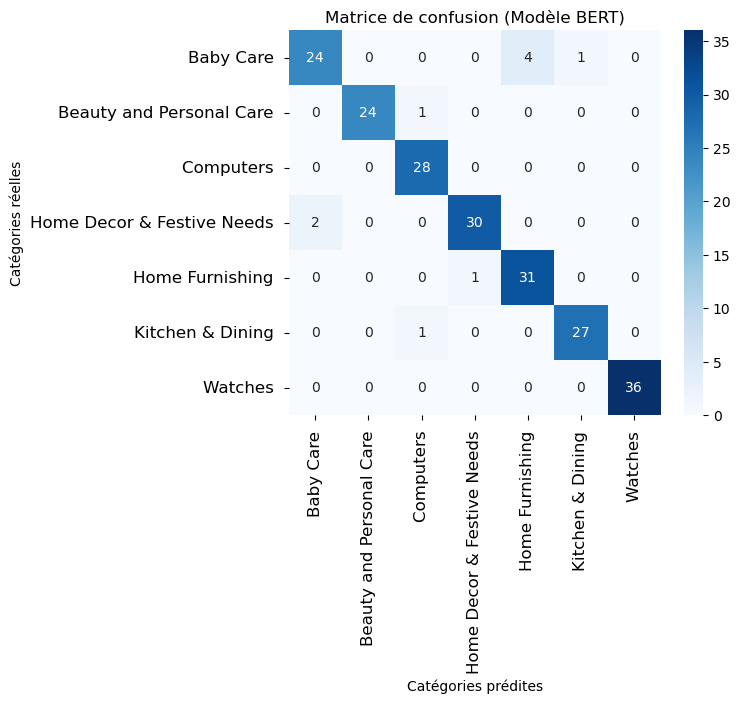

In [101]:
cm_bert  = metrics.confusion_matrix(test_lab, out_lab)
plt.figure( figsize=(6,5))
sns.heatmap(cm_bert, annot=True, cmap='Blues')
plt.xticks(np.arange(0.5, 7.5, 1), label.classes_, rotation = 90, fontsize=12)
plt.yticks(np.arange(0.5, 7.5, 1), label.classes_, rotation = 0, fontsize=12)
plt.xlabel('Catégories prédites')
plt.ylabel('Catégories réelles')
plt.title('Matrice de confusion (Modèle BERT)')
plt.savefig("./Visualisations/Comparaison/Matrice_de_confusion_BERT")
plt.show()

In [102]:
print("Recall :{:.2f}".format(metrics.recall_score(test_lab, out_lab, average='micro')))
print("Precision: {:.2f}".format(metrics.precision_score(test_lab, out_lab, average='micro')))
print("Accuracy:{:.2f}".format(metrics.accuracy_score(test_lab, out_lab)))

Recall :0.95
Precision: 0.95
Accuracy:0.95


## USE

In [103]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow_hub import KerasLayer

In [104]:
#Import modèle pré entrainé

in_layer = Input(shape=[], dtype=tf.string)
#hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embedding_layer = KerasLayer('./Notebook_Exemple/universal-sentence-encoder_4',
                    trainable=True)(in_layer)
d1_layer = Dense(256,activation = 'relu',
    kernel_regularizer=tf.keras.regularizers.L2(0.01))(embedding_layer)
dropout = Dropout(0.2)(d1_layer)
classifier = Dense(7,activation = 'softmax')(dropout)

model_use = Model(in_layer,classifier)

model_use.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 256,930,951
Trainable params: 256,930,951
Non-trainable params: 0
_________________________________________________________________


In [105]:
callbacks = [
    EarlyStopping(     #EarlyStopping pour stopper epoch quand val_accuracy ne s'ameliore pas
        monitor='val_loss',
        min_delta=1e-4,
        patience=4,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_loss', 
        mode='min', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [106]:
model_use.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy']) 

In [107]:
train_labels_ord = [np.argmax(out) for out in train_labels]

In [108]:
train_data2, valid_data, train_labels2, valid_labels = train_test_split(train_data, train_labels_ord, train_size=0.8)

In [109]:
start = time.time()

history = model_use.fit(train_data2.name_desc, 
          np.array(train_labels2), 
          batch_size=32, 
          validation_data=(valid_data.name_desc, np.array(valid_labels)), 
          epochs=10, 
          callbacks=callbacks)

train_time = (time.time() - start)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 4.2935 - accuracy: 0.5640
Epoch 1: val_loss improved from inf to 3.30468, saving model to weights.h5
21/21 [==============================] - 63s 3s/step - loss: 4.2935 - accuracy: 0.5640 - val_loss: 3.3047 - val_accuracy: 0.7500
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 2.5612 - accuracy: 0.8571
Epoch 2: val_loss improved from 3.30468 to 1.96165, saving model to weights.h5
21/21 [==============================] - 53s 3s/step - loss: 2.5612 - accuracy: 0.8571 - val_loss: 1.9616 - val_accuracy: 0.8571
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 1.4484 - accuracy: 0.9449
Epoch 3: val_loss improved from 1.96165 to 1.22041, saving model to weights.h5
21/21 [==============================] - 51s 2s/step - loss: 1.4484 - accuracy: 0.9449 - val_loss: 1.2204 - val_accuracy: 0.9048
Epoch 4/10
21/21 [==============================] - ETA: 0s - loss: 0.8486 - accuracy: 0.9807
Epoc

In [110]:
df_model.loc['USE','Train_Time'] = train_time
df_model.loc['USE','Train_Accuracy'] = max(history.history['accuracy'])

In [111]:
start = time.time()
out_use = model_use.predict(test_data.name_desc)
test_time = (time.time() - start)

7/7 [==============================] - 0s 16ms/step


In [112]:
use_lab = [np.argmax(out) for out in out_use]

In [113]:
df_model.loc['USE','Test_Time'] = test_time
df_model.loc['USE','Test_Accuracy'] = metrics.accuracy_score(test_lab, use_lab)

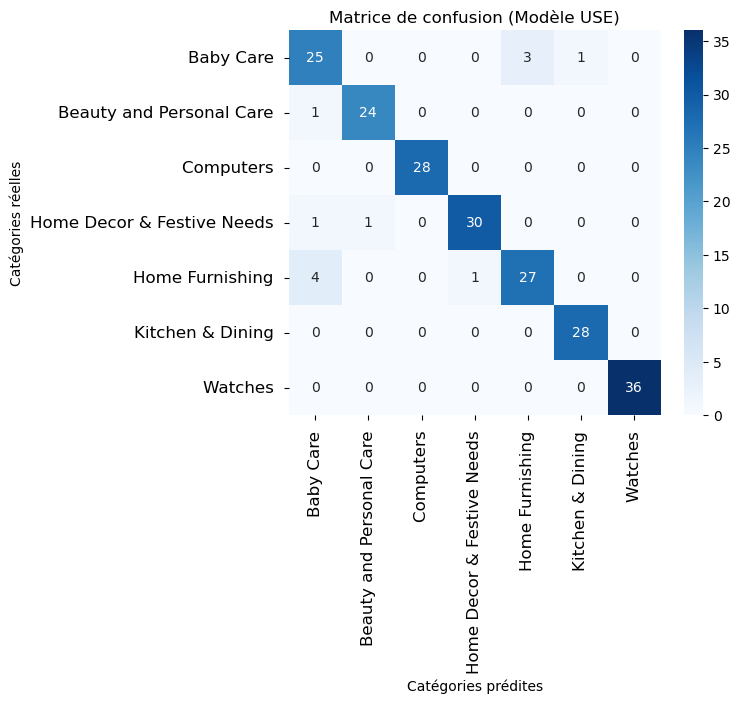

In [114]:
cm_use = metrics.confusion_matrix(test_lab, use_lab)
plt.figure( figsize=(6,5))
sns.heatmap(cm_use, annot=True, cmap='Blues')
plt.xticks(np.arange(0.5, 7.5, 1), label.classes_, rotation = 90, fontsize=12)
plt.yticks(np.arange(0.5, 7.5, 1), label.classes_, rotation = 0, fontsize=12)
plt.xlabel('Catégories prédites')
plt.ylabel('Catégories réelles')
plt.title('Matrice de confusion (Modèle USE)')
plt.savefig("./Visualisations/Comparaison/Matrice_de_confusion_USE")
plt.show()

In [115]:
print("Recall :{:.2f}".format(metrics.recall_score(test_lab, use_lab, average='micro')))
print("Precision: {:.2f}".format(metrics.precision_score(test_lab, use_lab, average='micro')))
print("Accuracy:{:.2f}".format(metrics.accuracy_score(test_lab, use_lab)))

Recall :0.94
Precision: 0.94
Accuracy:0.94


In [129]:
df_model

Train_Accuracy   Train_Time Test_Accuracy  Test_Time
CountVectorizer       0.671429    19.497707      0.314286   0.022903
TfidfVectorizer       0.620238    12.906792      0.114286   0.018948
Doc2Vec               0.821429   345.167994      0.666667   1.172099
BERT                  0.901786  7961.198062      0.952381  58.864084
USE                        1.0   496.365633      0.942857   0.495489

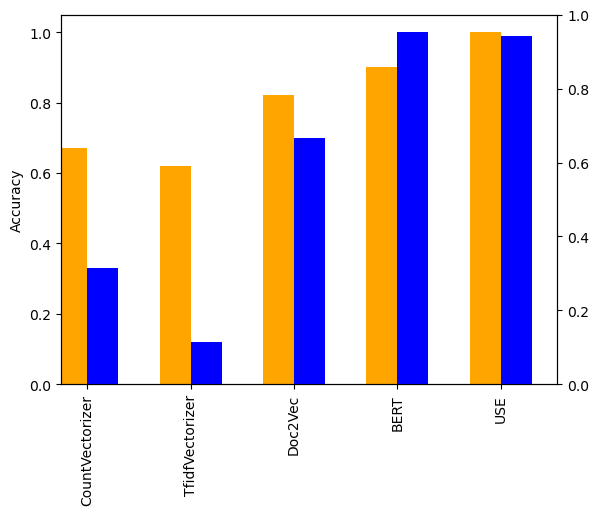

In [144]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.set_ylabel('Accuracy')

width=0.3

df_model['Train_Accuracy'].plot(kind='bar',color='orange',ax=ax1,width=width,position=1)
df_model['Test_Accuracy'].plot(kind='bar',color='blue',ax=ax2,width=width,position=0)

plt.show()